In [4]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('main.csv')

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Масштабируем по каждому району
scalers = {}
sequences = []

seq_len = 4

# Группируем по району
for region_id, group in df.groupby('Район'):
    group = group.sort_values('Год')
    scaler = MinMaxScaler()
    features = ['Цена', 'Ковид', 'Санкции', 'Ключевая ставка ЦБ РФ (%)', 'ИПЦ (% к декабрю предыдущего года)', 'Доллар']
    
    scaled_data = scaler.fit_transform(group[features])
    scalers[region_id] = scaler

    for i in range(len(scaled_data) - seq_len):
        X_seq = scaled_data[i:i+seq_len, 1:]  # все признаки кроме 'Цена'
        y_seq = scaled_data[i+seq_len, 0]     # целевая — Цена
        sequences.append((X_seq, y_seq))

# Преобразуем в массивы
X_all = np.array([s[0] for s in sequences])
y_all = np.array([s[1] for s in sequences])

# Разделим на train/test: последние 2 года — тест
split_idx = int(0.92 * len(X_all))
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

In [6]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, X_train.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1455 - val_loss: 0.0221
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0190 - val_loss: 0.0065
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R2 Score': r2
    }

In [9]:
y_pred = model.predict(X_test)

print(evaluate_model(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
{'MAE': 0.02750991643659917, 'MSE': 0.00174139181504923, 'RMSE': np.float64(0.041729987000348204), 'MAPE (%)': np.float64(74.61760723106016), 'R2 Score': 0.9713278492133307}


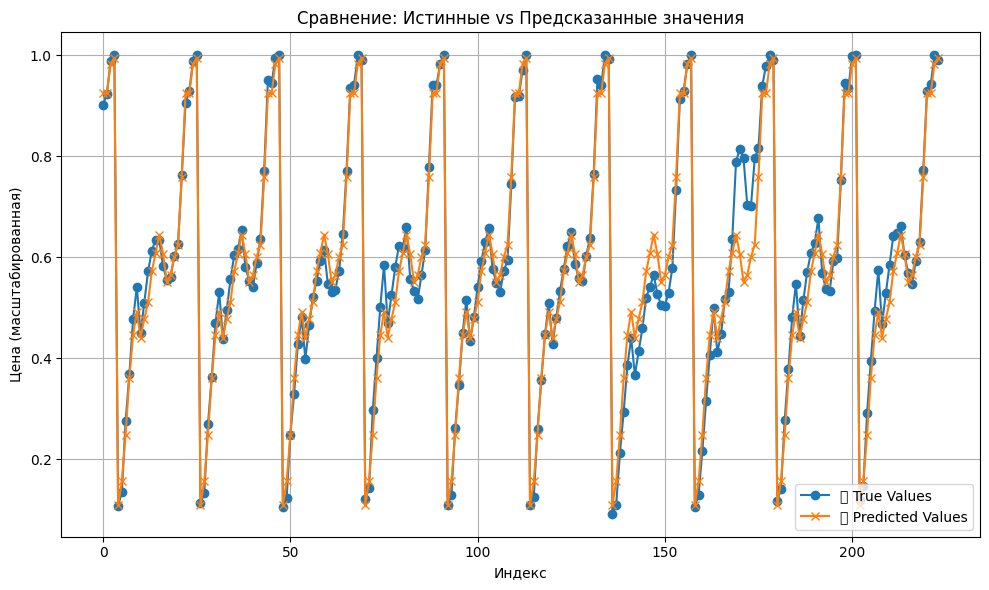

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='🔹 True Values', marker='o')
plt.plot(y_pred, label='🔸 Predicted Values', marker='x')
plt.title('Сравнение: Истинные vs Предсказанные значения')
plt.xlabel('Индекс')
plt.ylabel('Цена (масштабированная)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Second LSTM

In [7]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import numpy as np

y_test_dict = {}
y_pred_dict = {}
scalers = {}

for rayon in df['Район'].unique():
    df_r = df[df['Район'] == rayon].sort_values('Год')

    # Признаки и целевая переменная
    features = ['Ковид', 'Санкции', 'Ключевая ставка ЦБ РФ (%)', 'ИПЦ (% к декабрю предыдущего года)', 'Доллар']
    target = 'Цена'

    df_r_feat = df_r[features + [target]]
    
    # Масштабирование
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_r_feat)
    scalers[rayon] = scaler
    
    X = scaled_data[:, :-1]
    y = scaled_data[:, -1]

    # Создание временных окон (lag = 3)
    def create_sequences(X, y, lag=3):
        Xs, ys = [], []
        for i in range(lag, len(X)):
            Xs.append(X[i-lag:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_seq, y_seq = create_sequences(X, y)

    # Train/Test split (последние 2 года = test)
    test_size = 2
    X_train, X_test = X_seq[:-test_size], X_seq[-test_size:]
    y_train, y_test = y_seq[:-test_size], y_seq[-test_size:]

    # Модель
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Прогноз
    y_pred = model.predict(X_test)

    # Сохраняем
    y_test_dict[rayon] = y_test
    y_pred_dict[rayon] = y_pred.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
y_test_inv_all = {}
y_pred_inv_all = {}

for rayon in y_test_dict:
    scaler = scalers[rayon]
    
    y_test = y_test_dict[rayon]
    y_pred = y_pred_dict[rayon]
    
    dummy_test = np.zeros((len(y_test), len(scaler.feature_names_in_)))
    dummy_pred = np.zeros_like(dummy_test)
    
    dummy_test[:, -1] = y_test
    dummy_pred[:, -1] = y_pred
    
    y_test_inv_all[rayon] = scaler.inverse_transform(dummy_test)[:, -1]
    y_pred_inv_all[rayon] = scaler.inverse_transform(dummy_pred)[:, -1]


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R2 Score': r2
    }

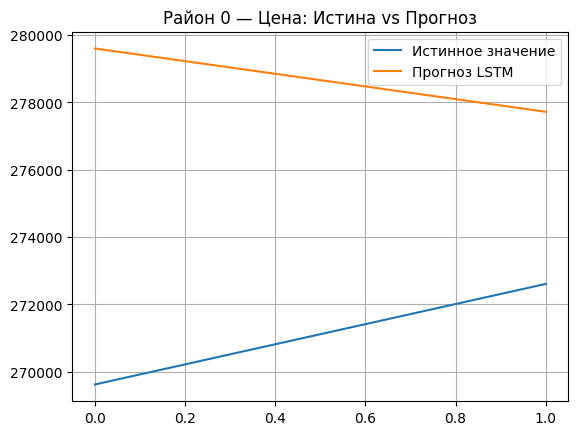

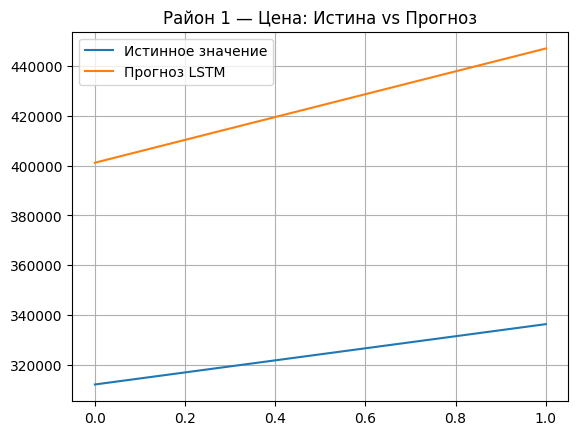

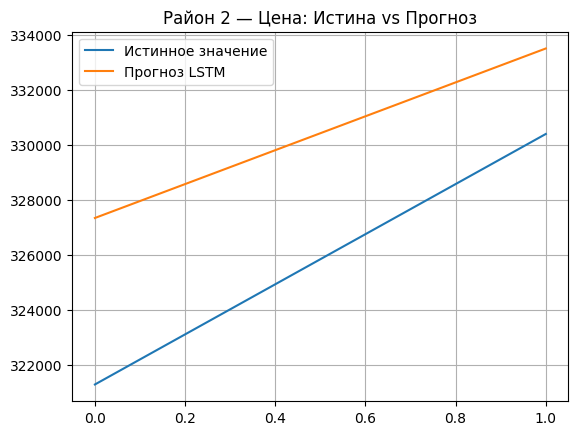

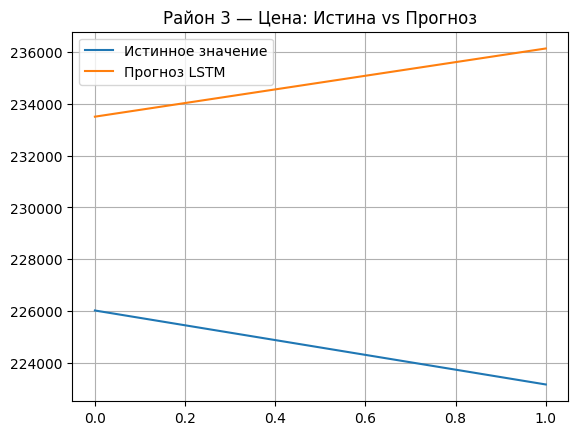

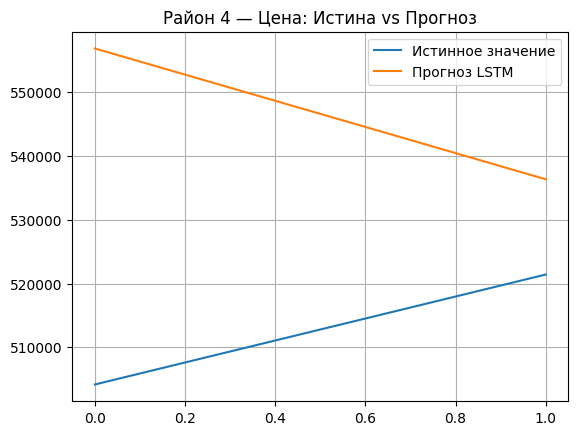

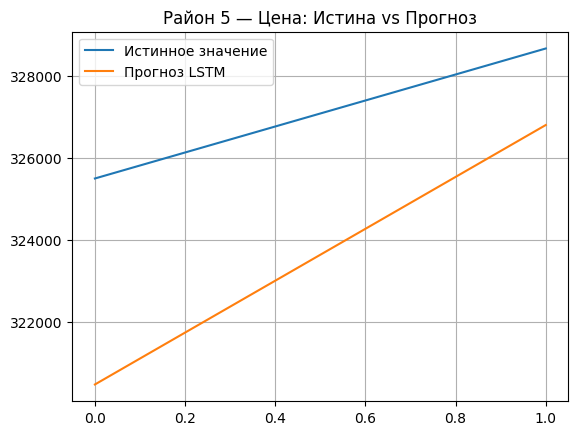

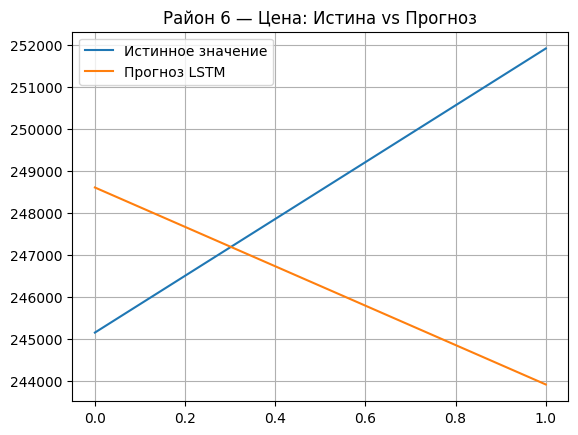

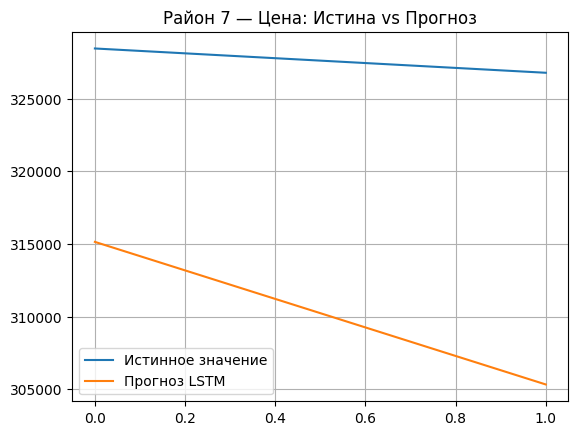

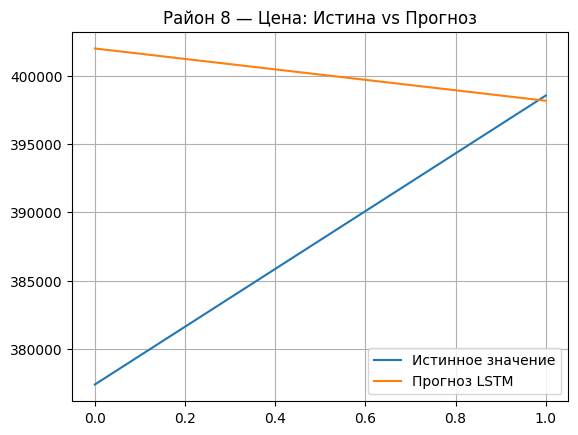

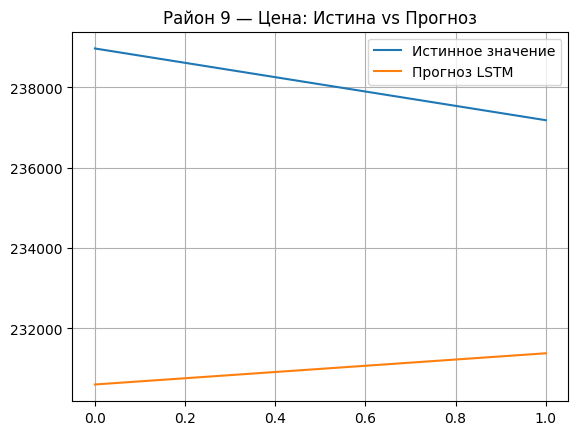

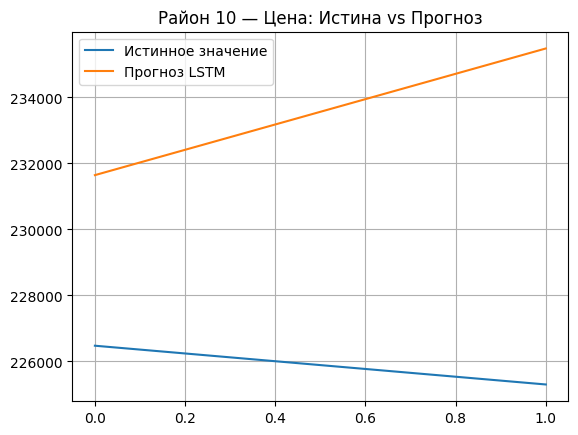

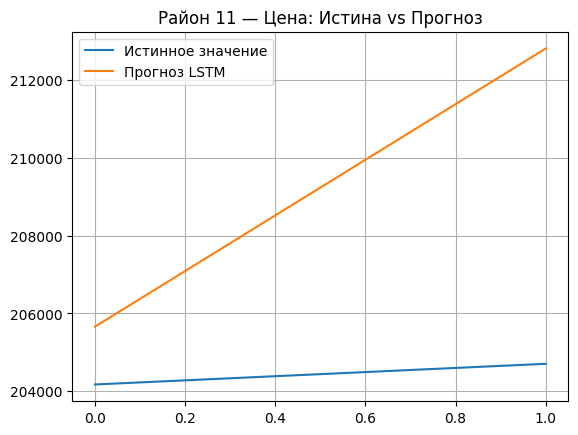

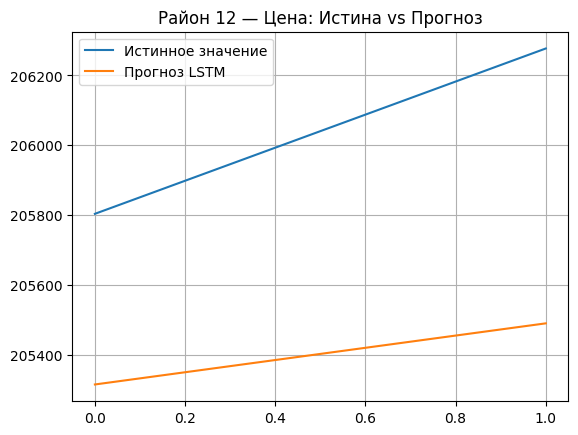

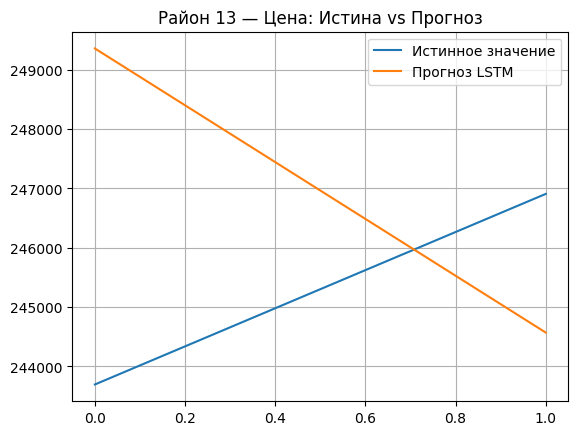

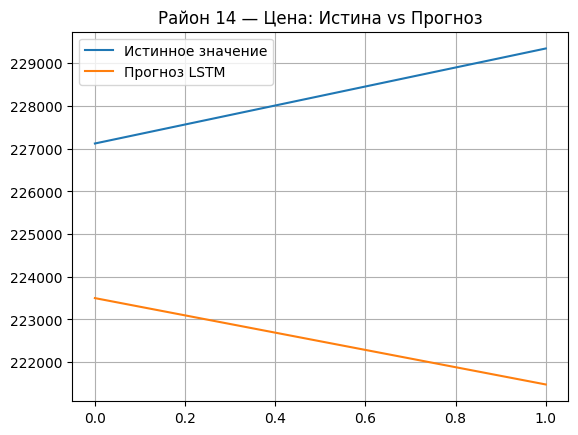

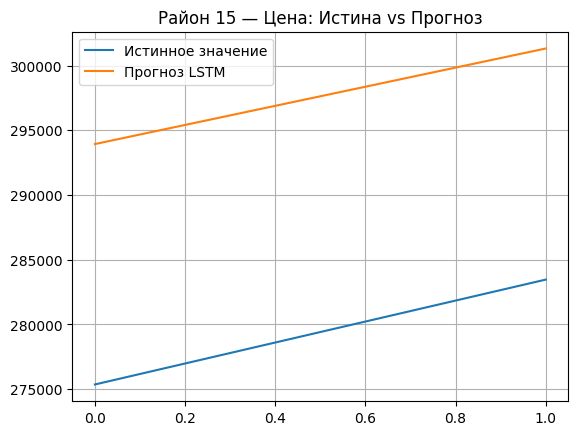

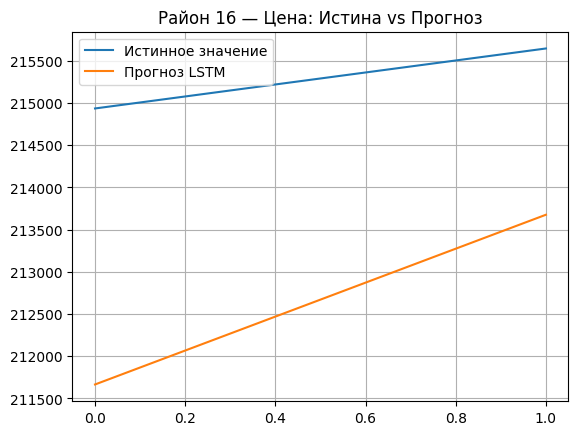

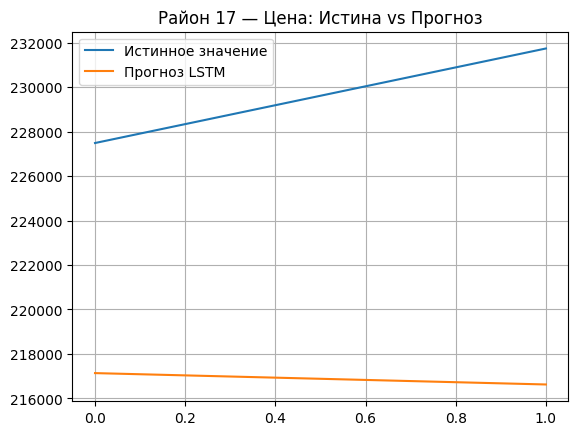

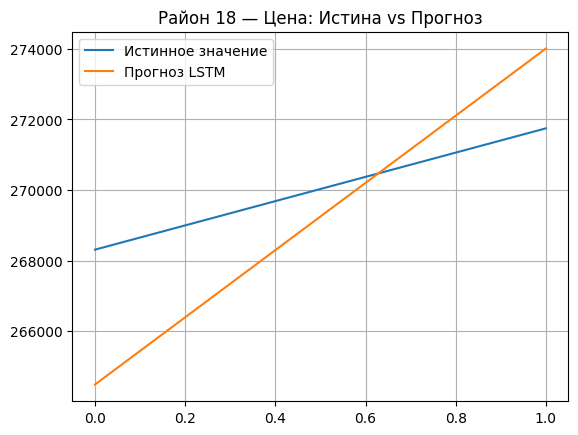

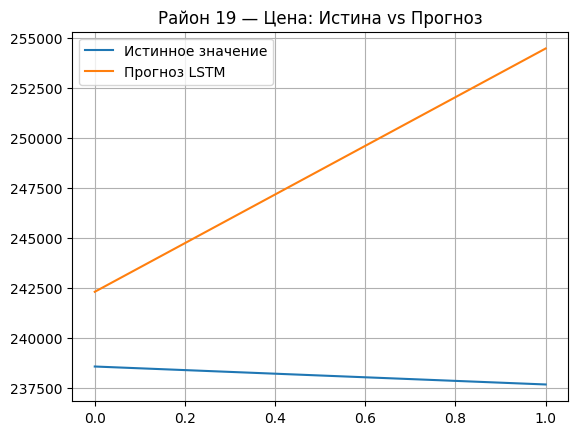

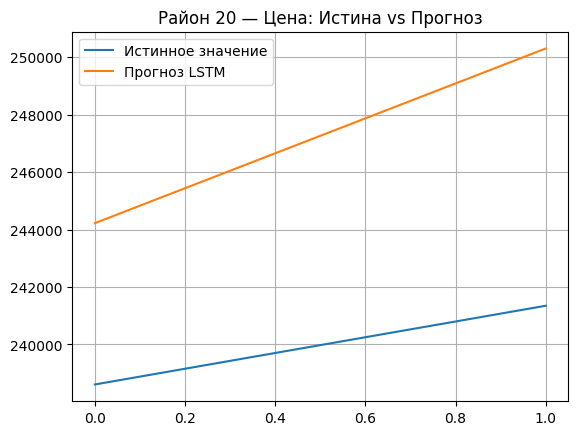

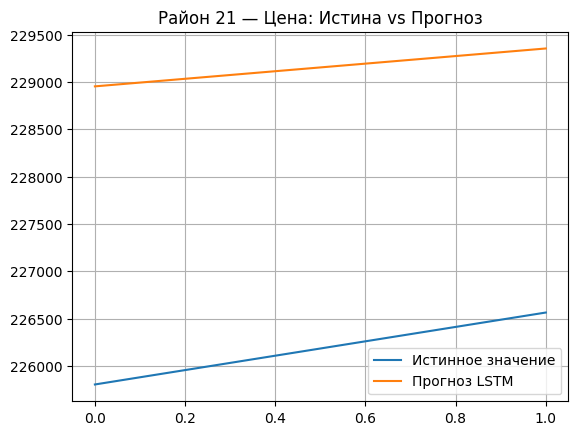

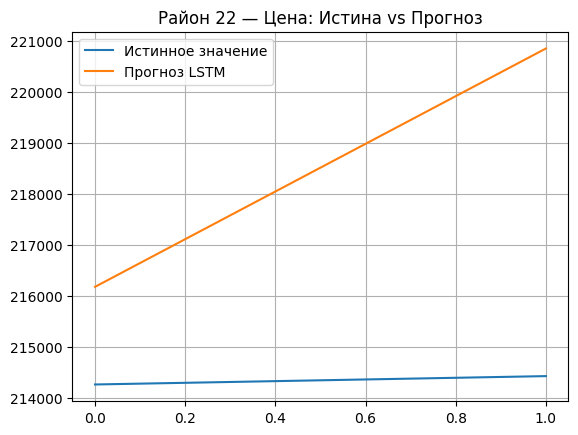

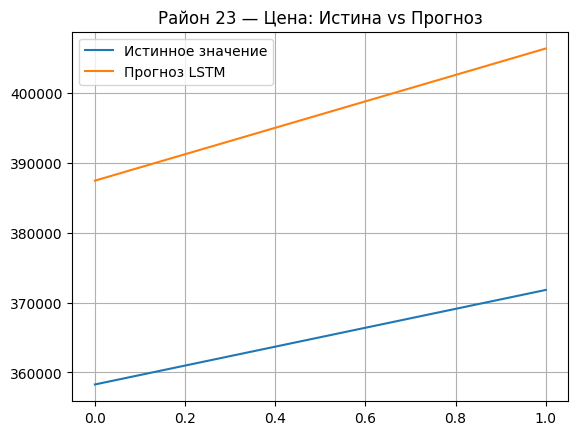

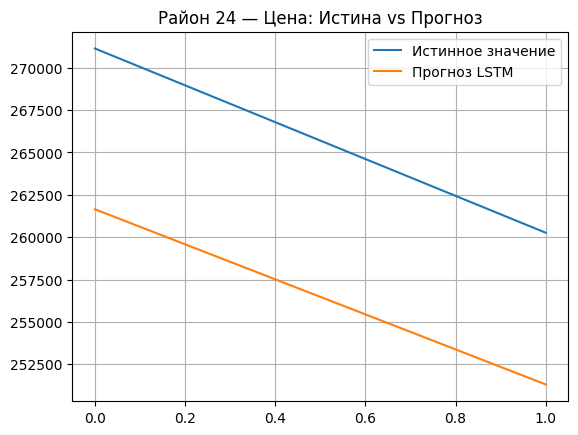

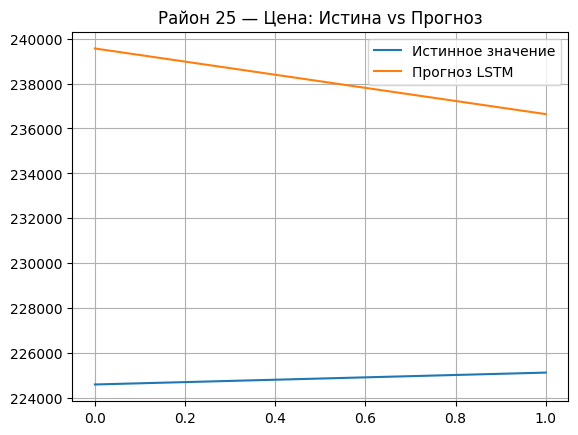

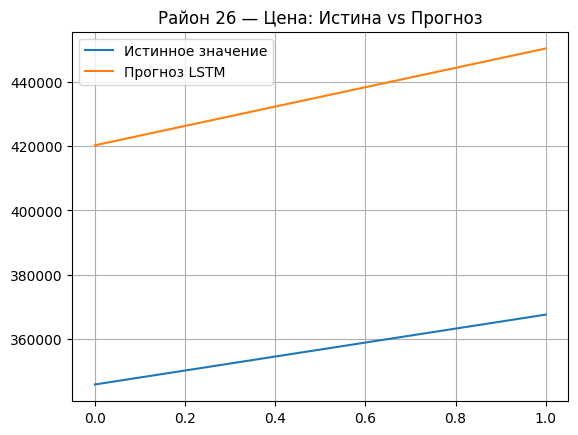

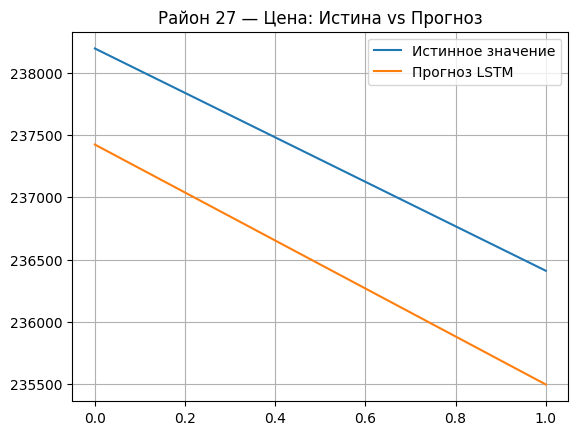

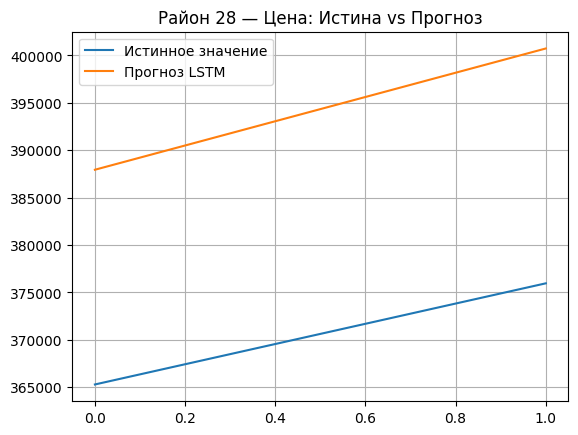

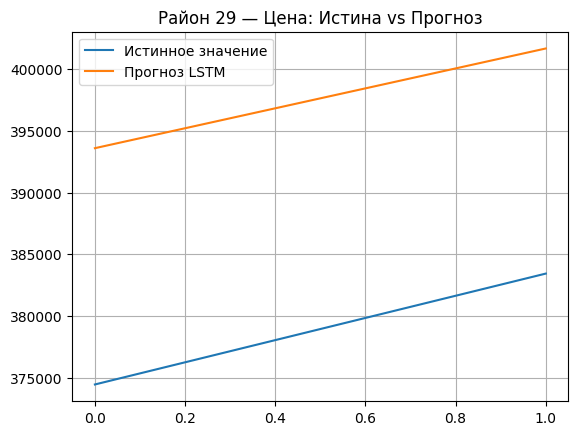

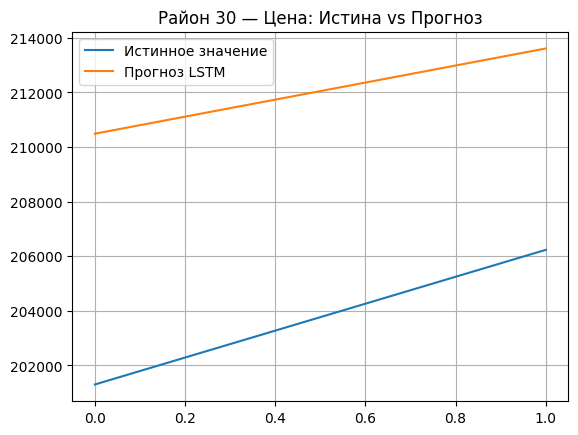

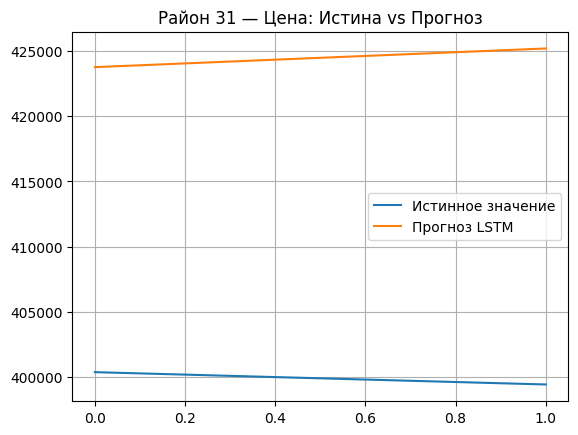

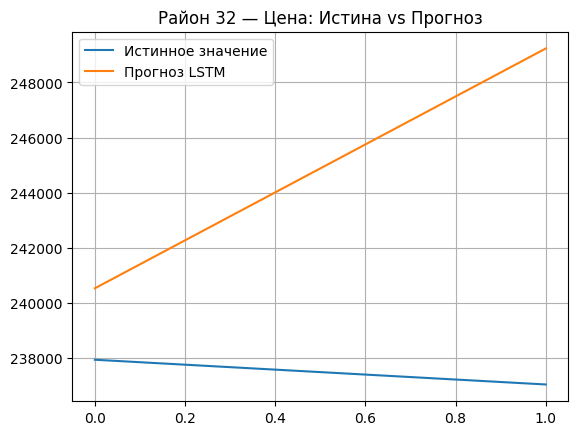

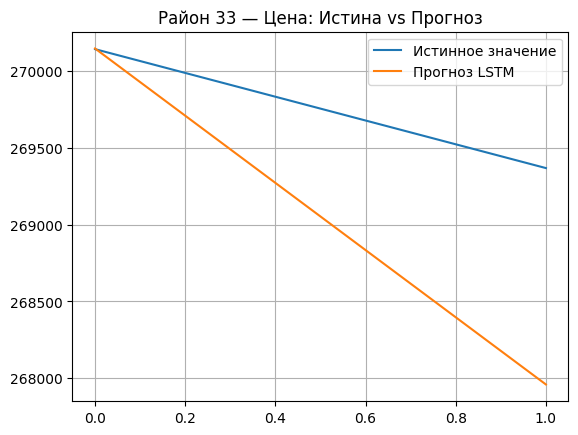

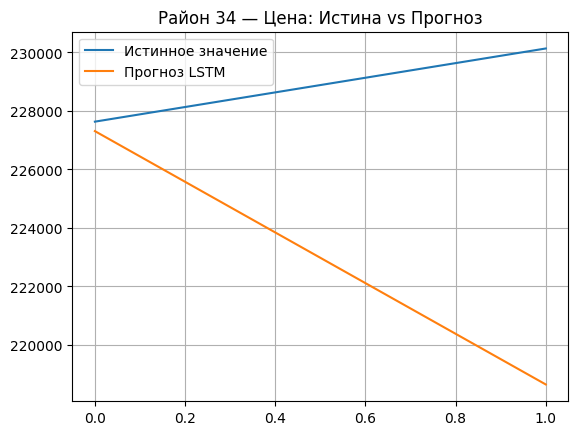

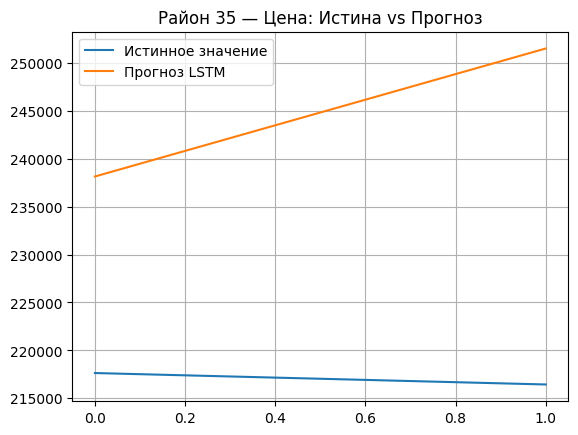

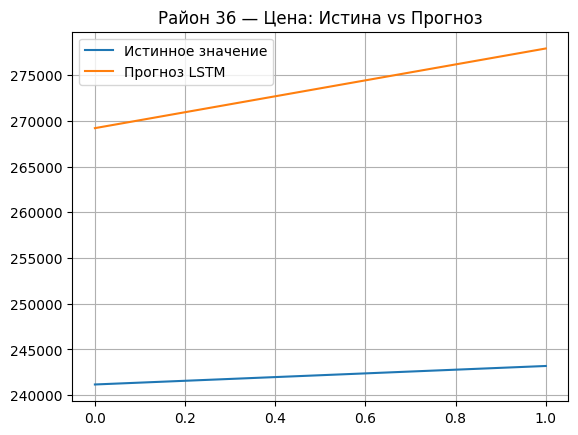

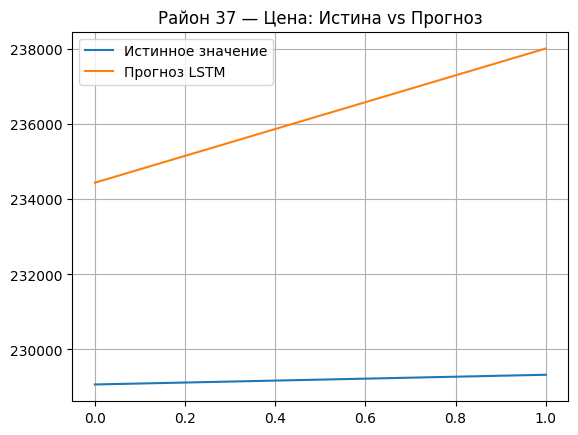

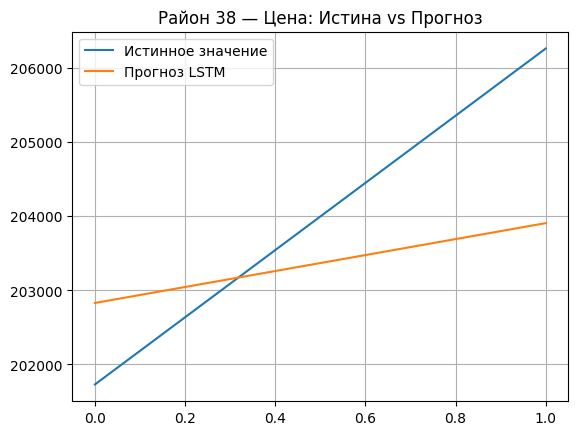

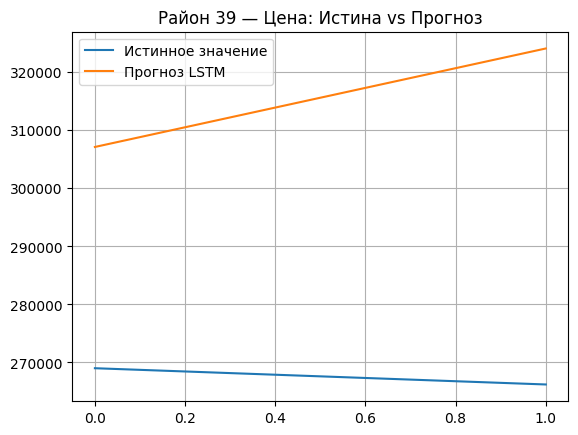

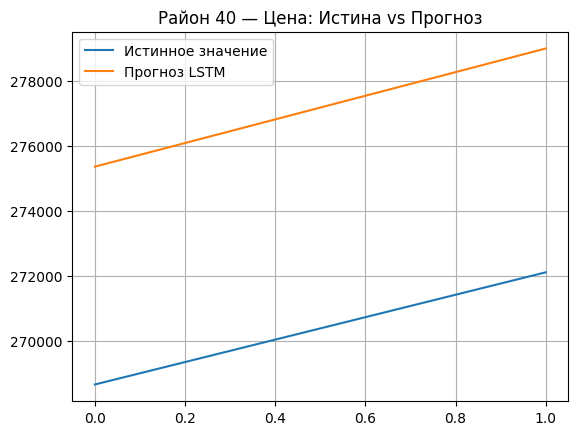

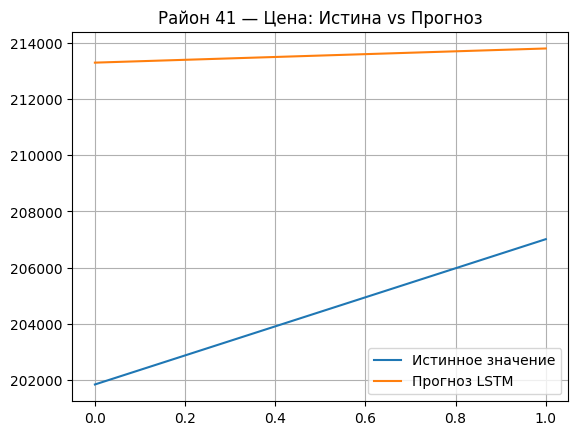

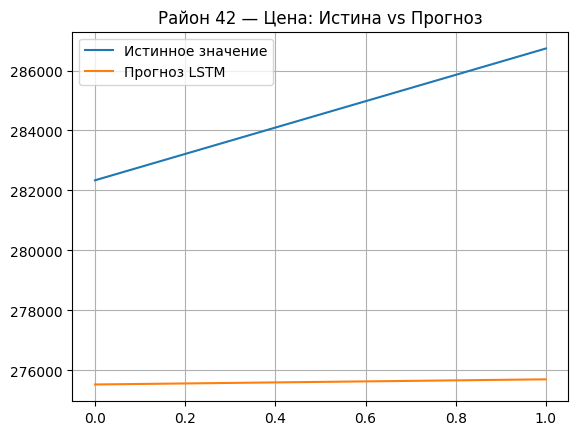

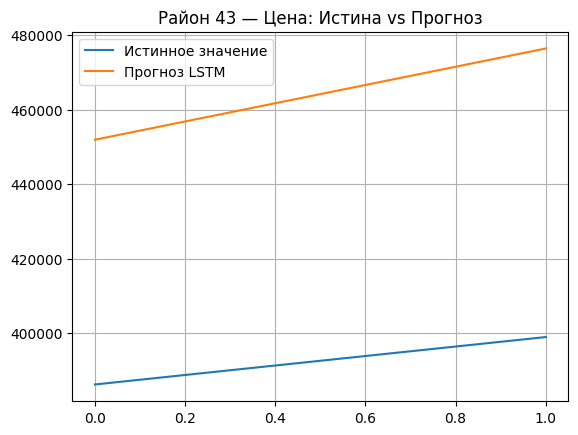

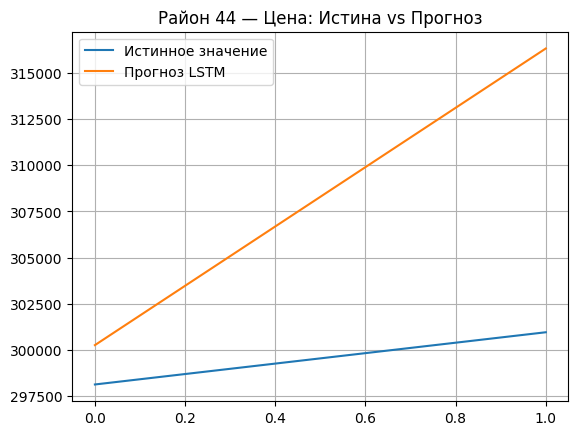

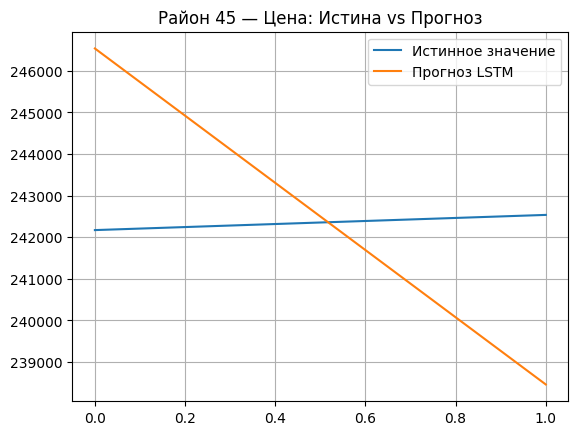

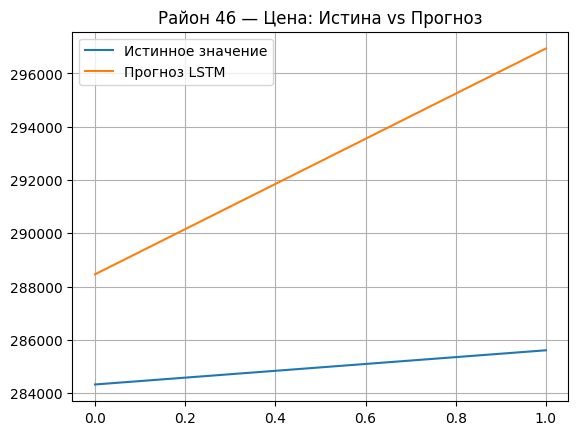

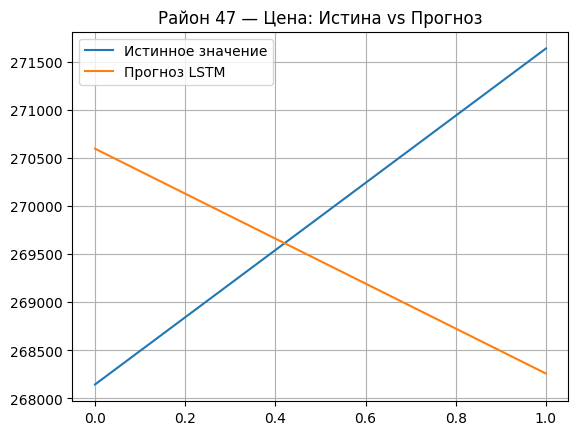

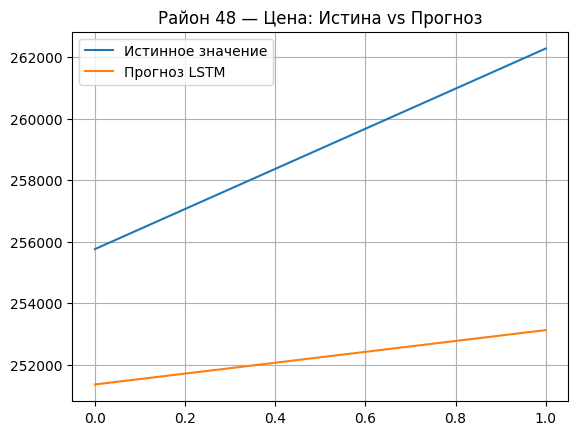

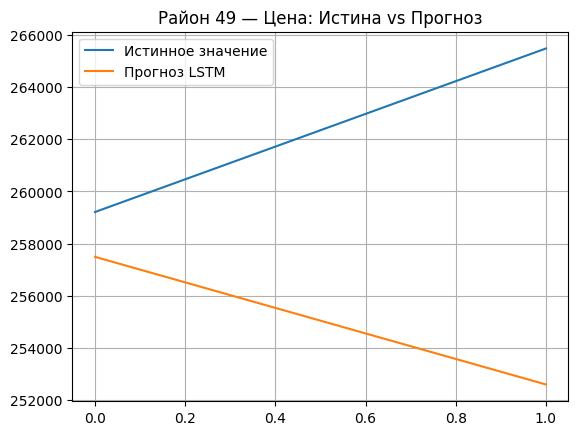

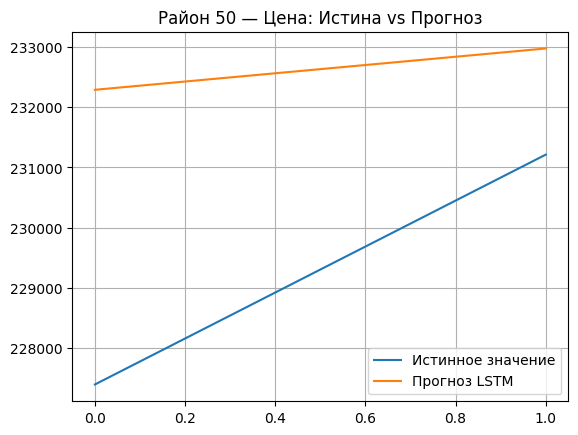

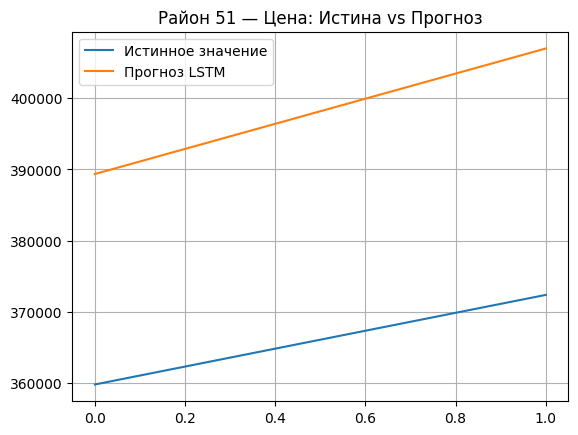

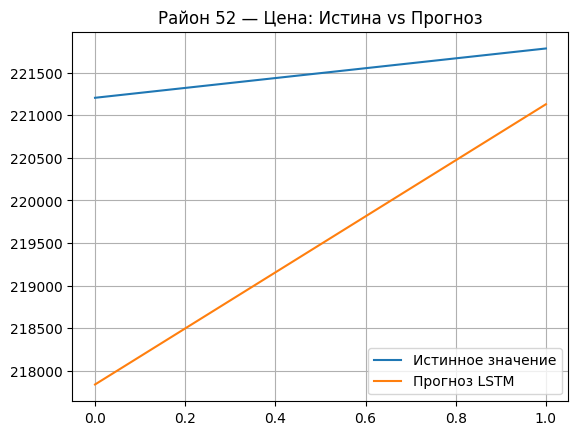

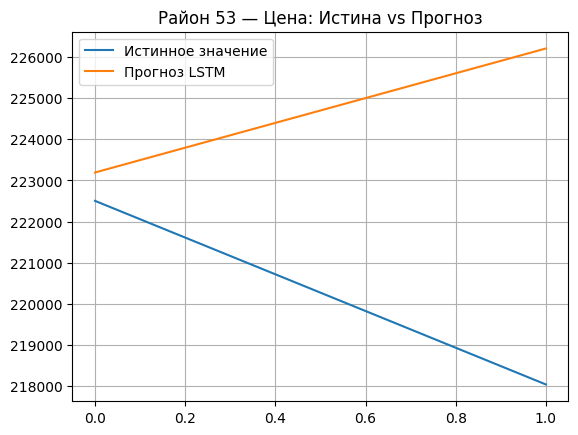

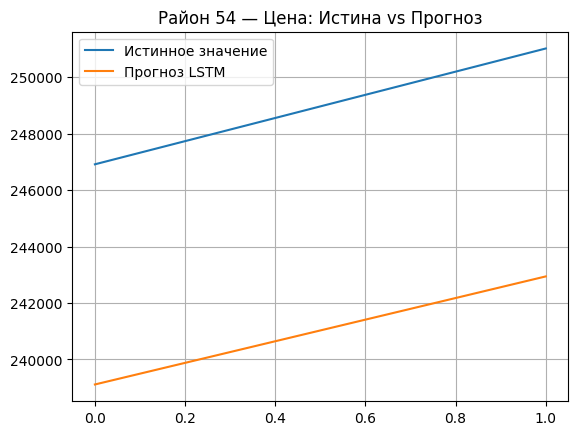

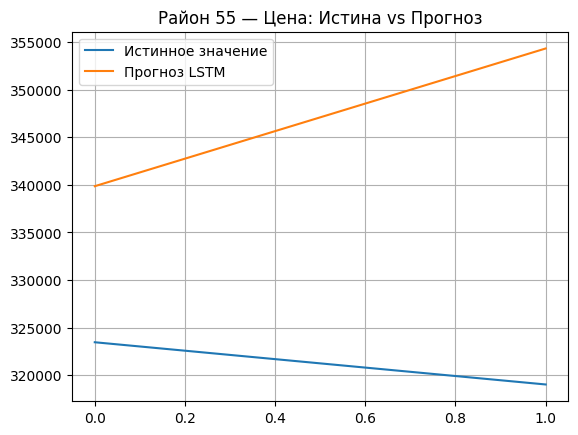

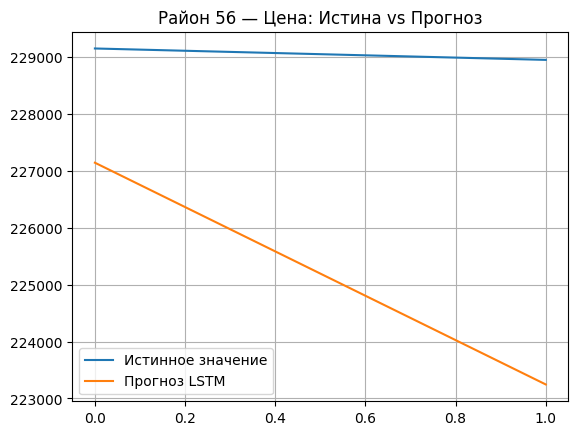

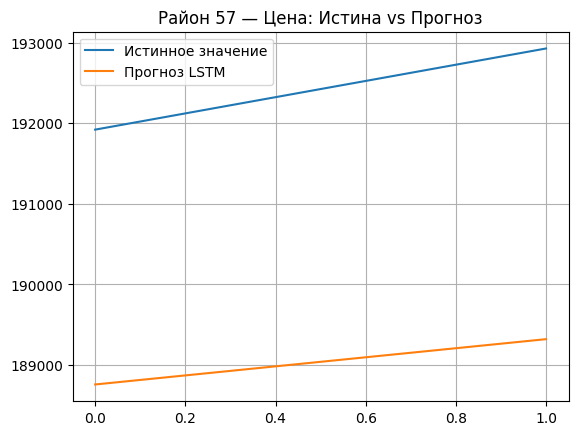

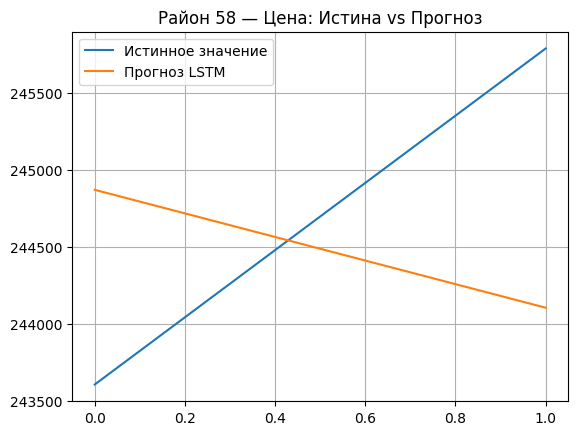

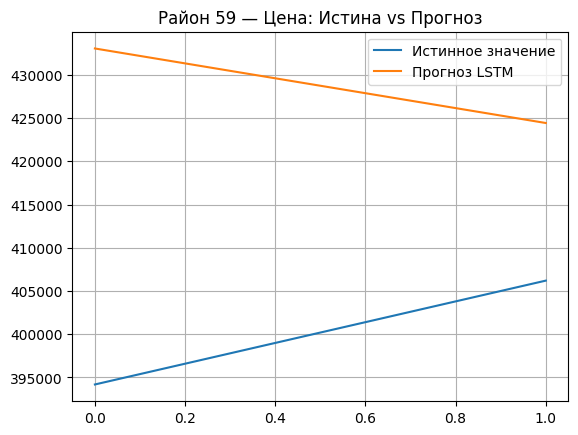

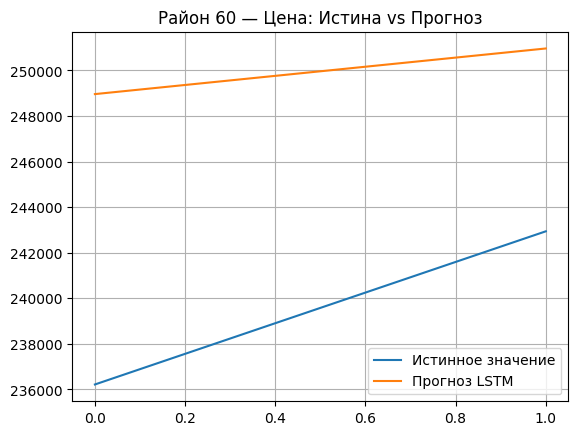

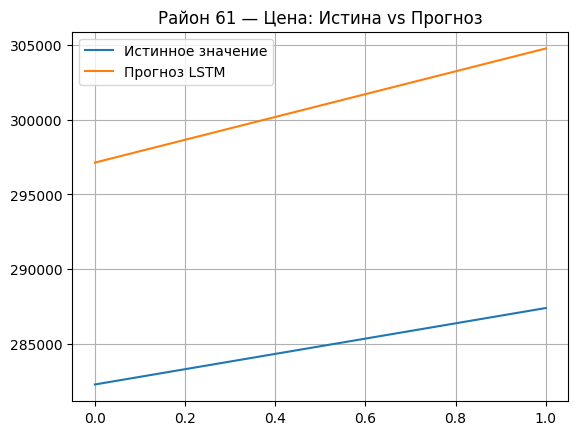

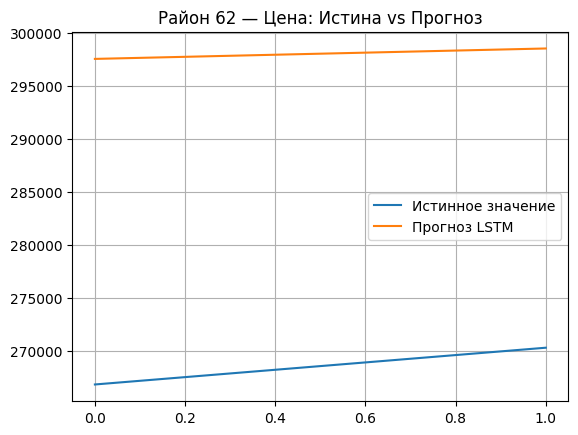

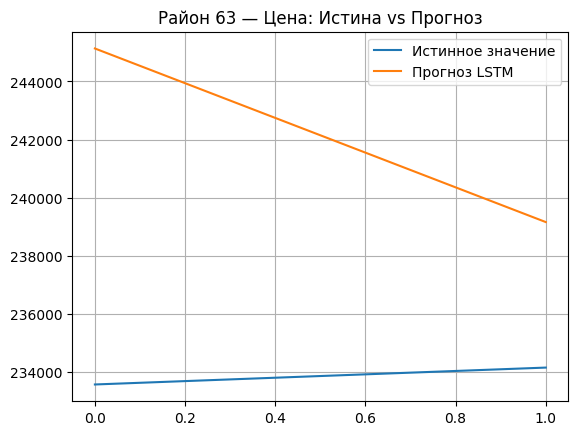

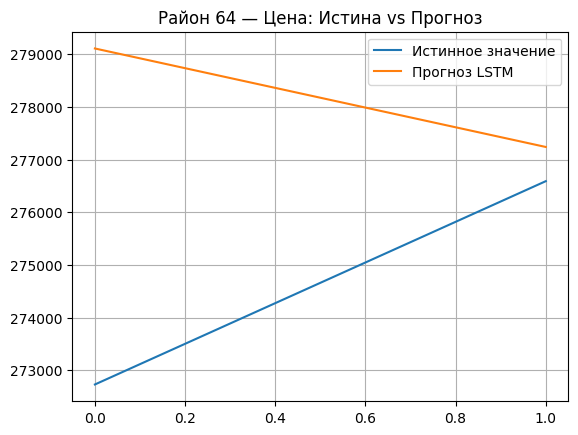

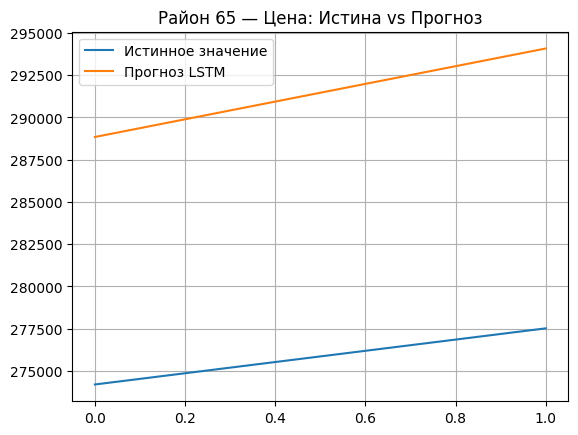

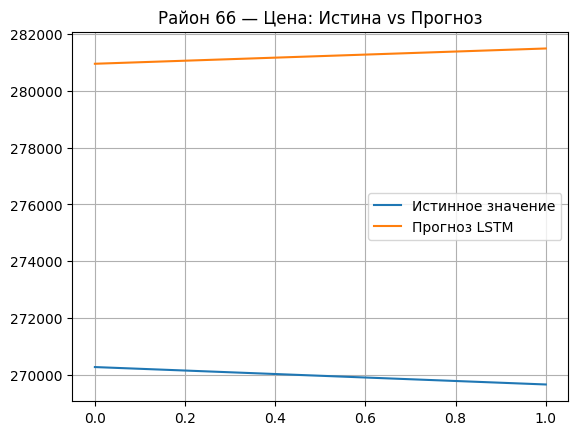

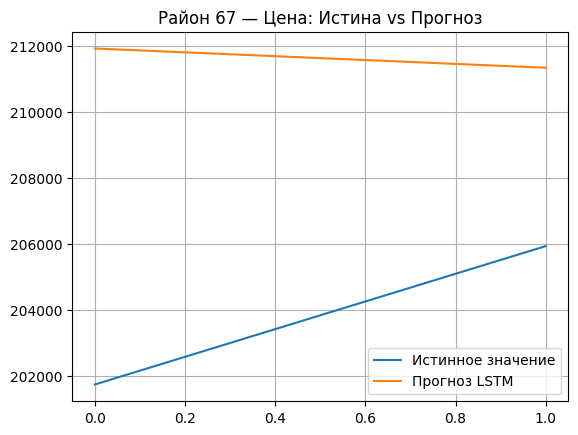

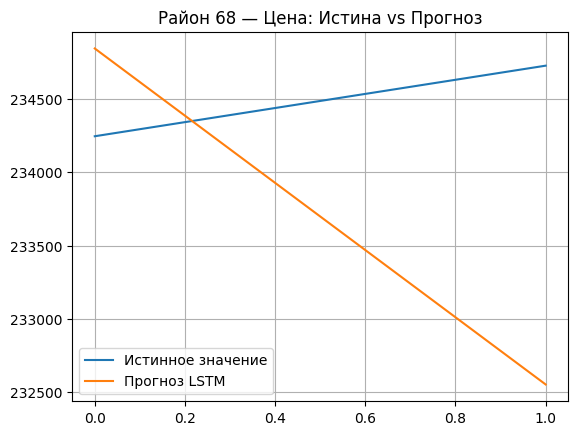

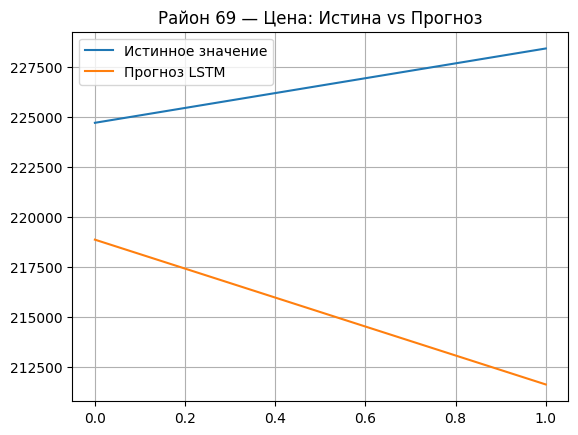

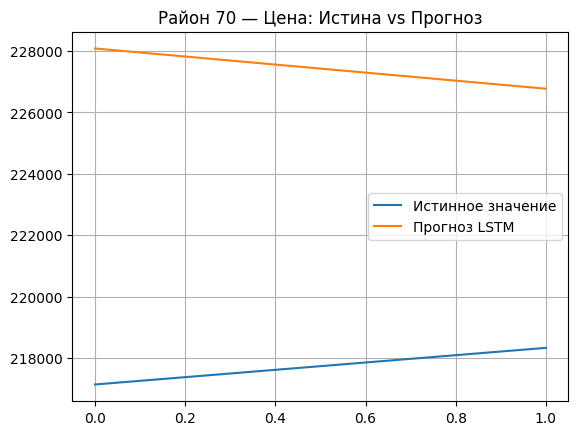

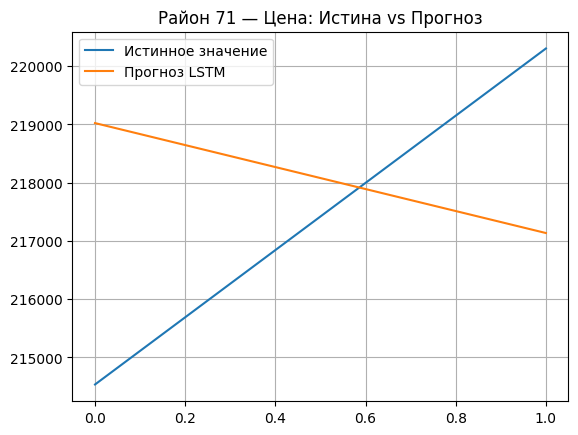

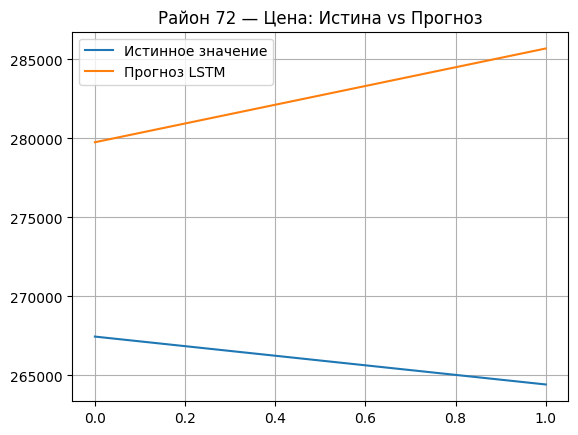

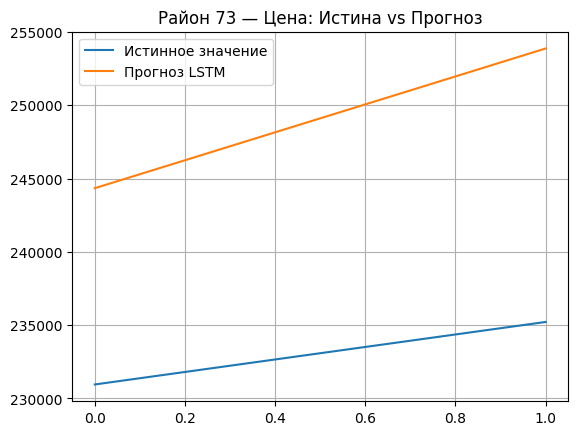

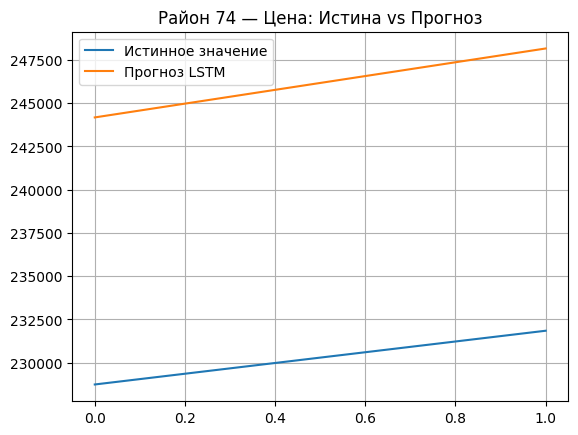

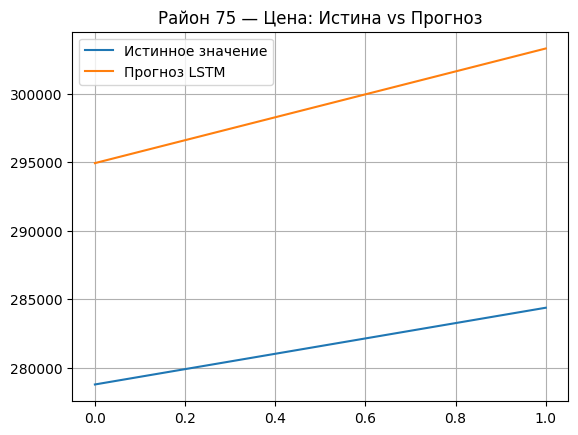

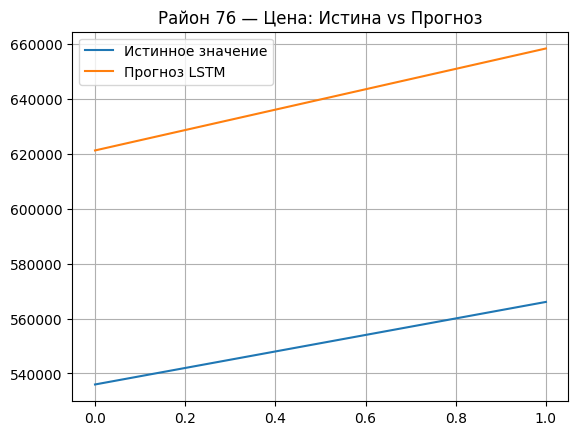

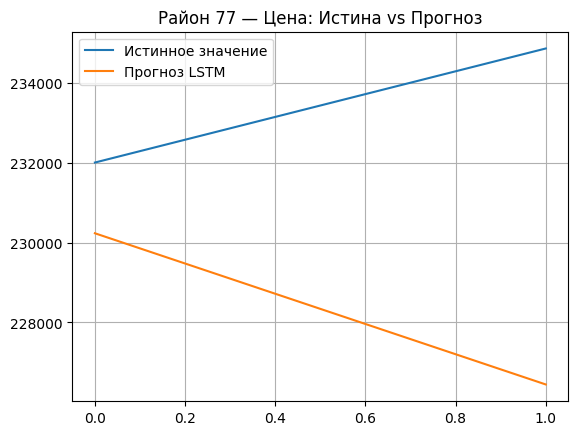

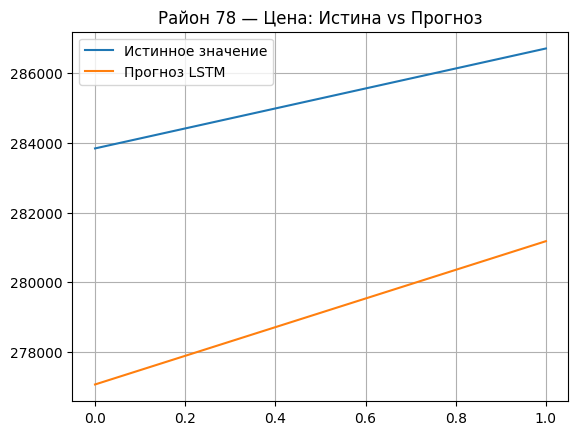

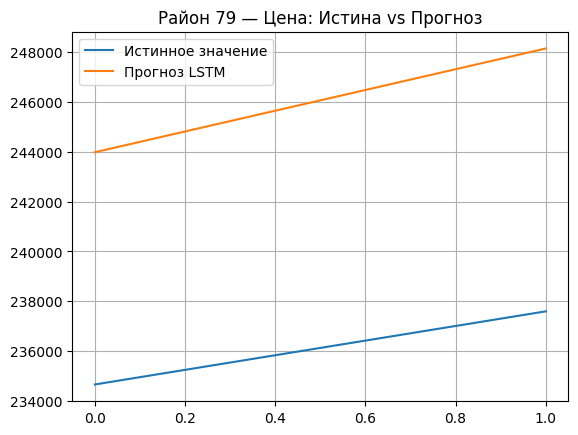

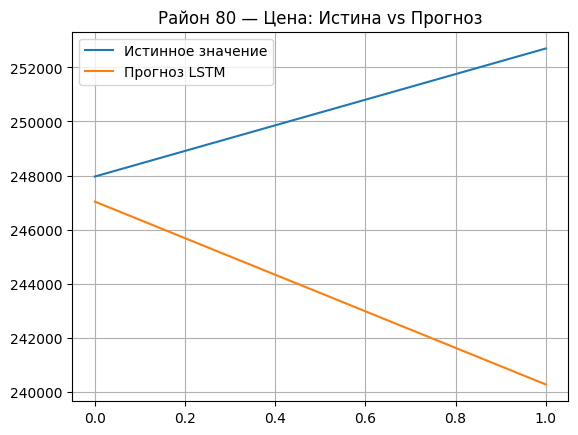

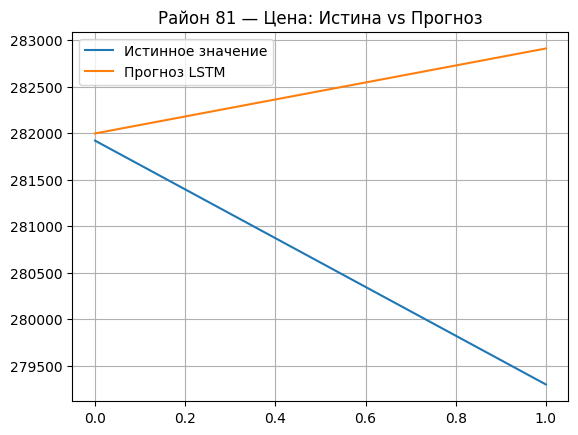

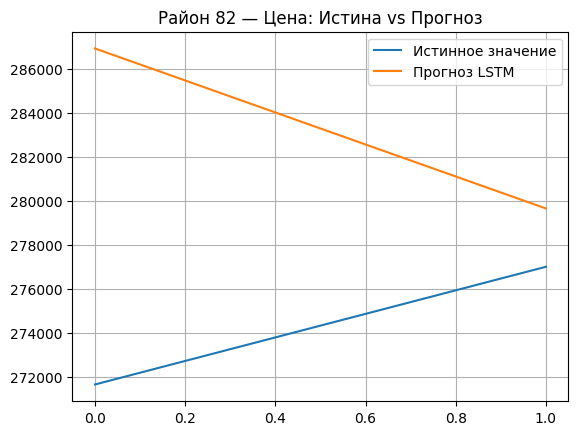

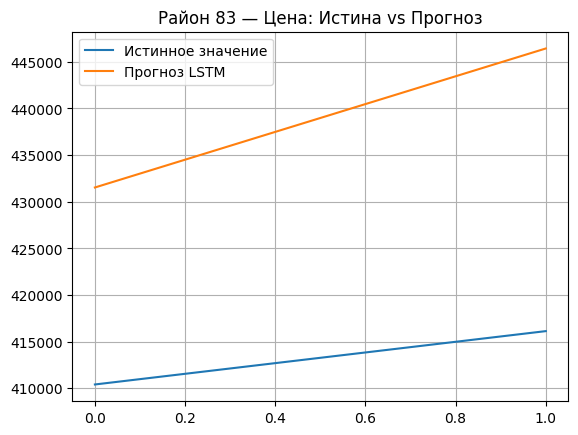

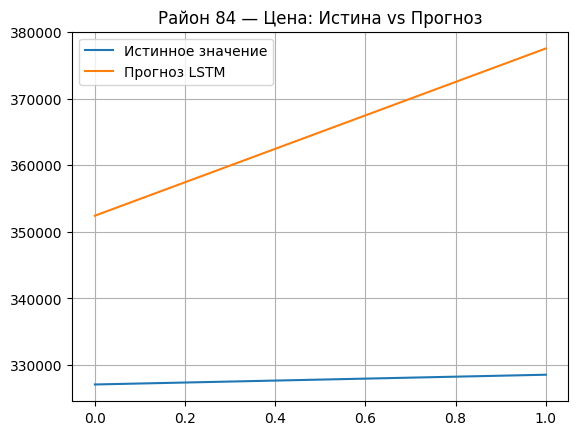

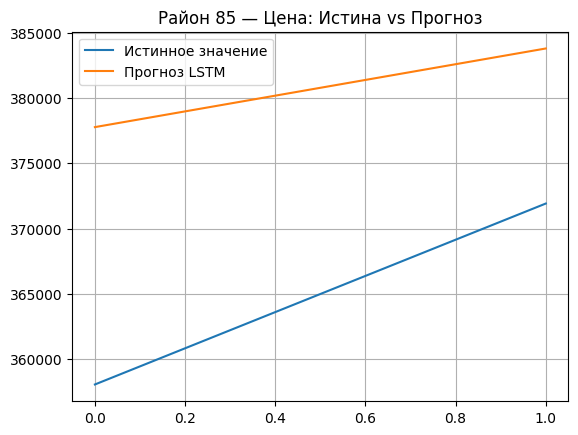

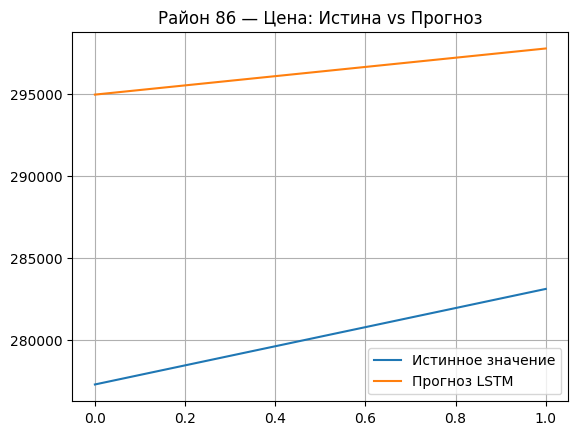

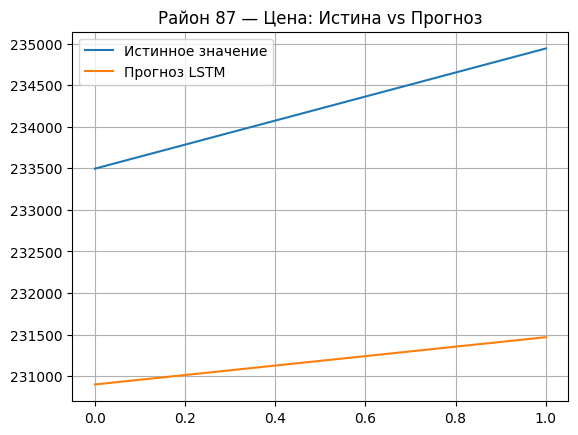

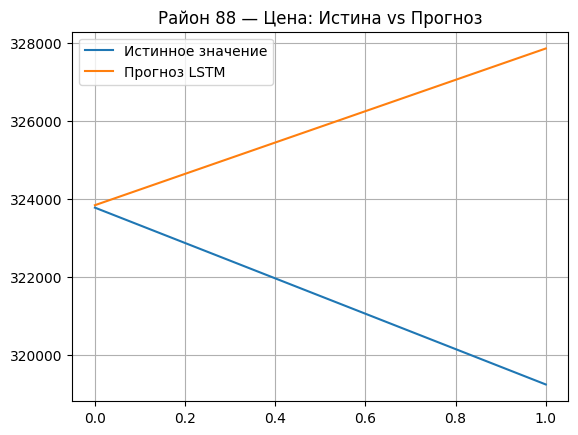

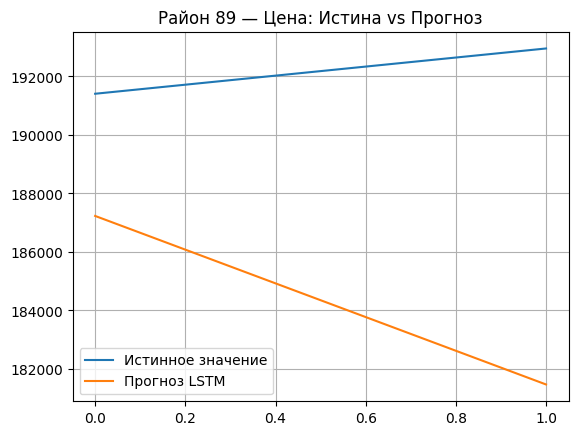

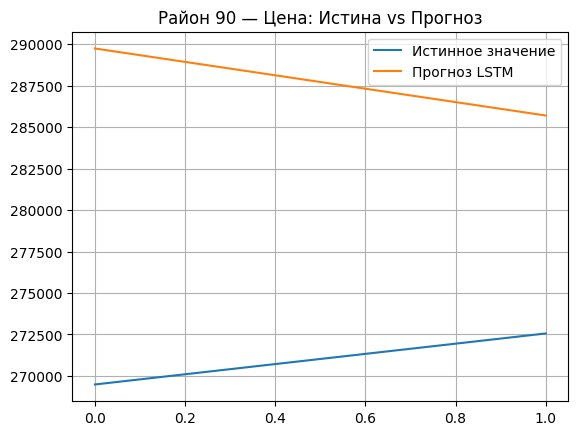

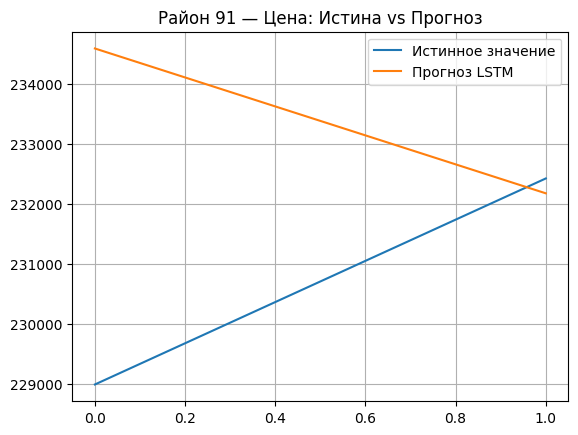

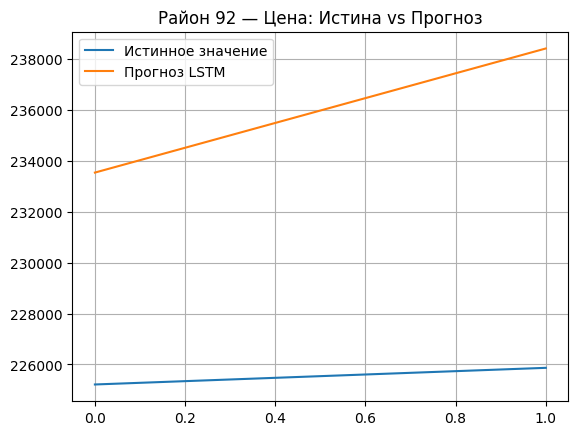

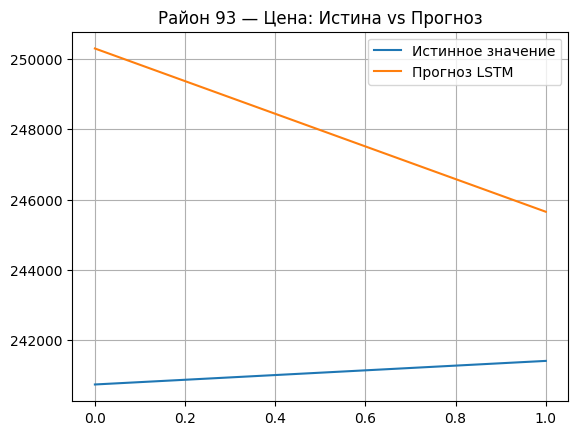

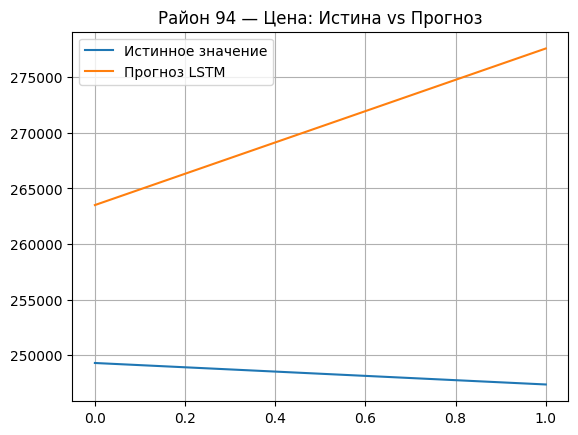

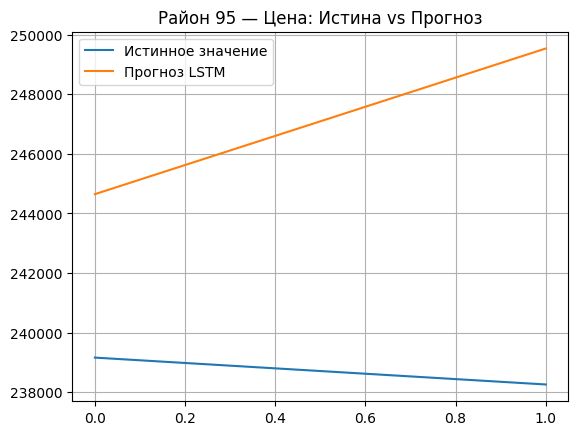

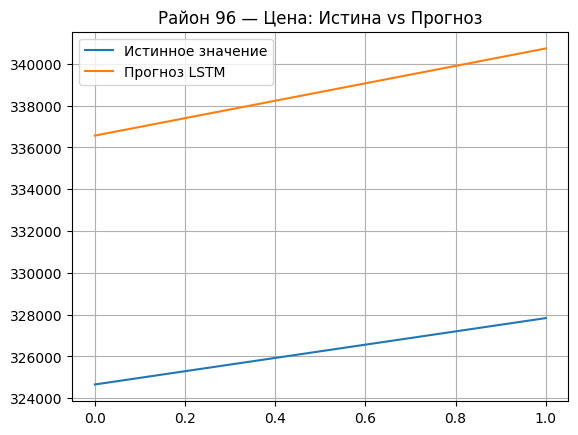

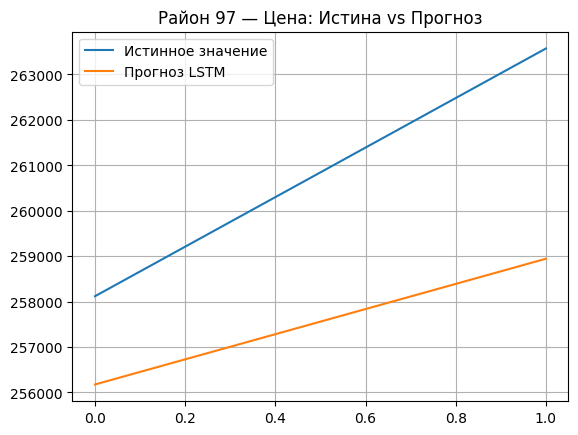

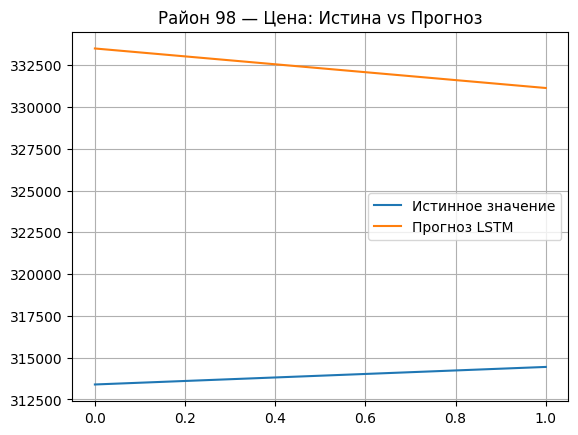

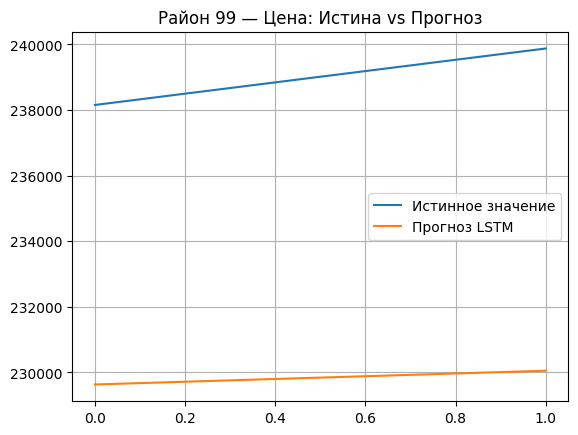

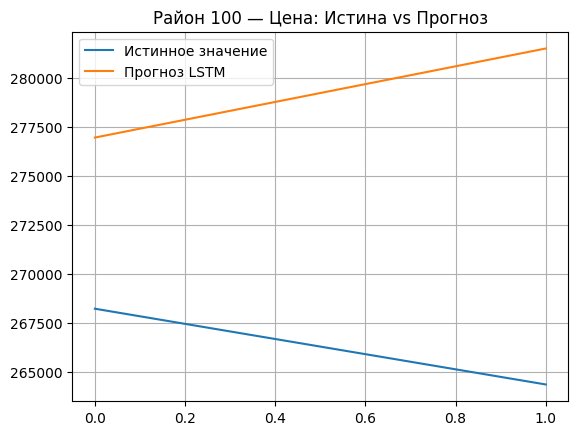

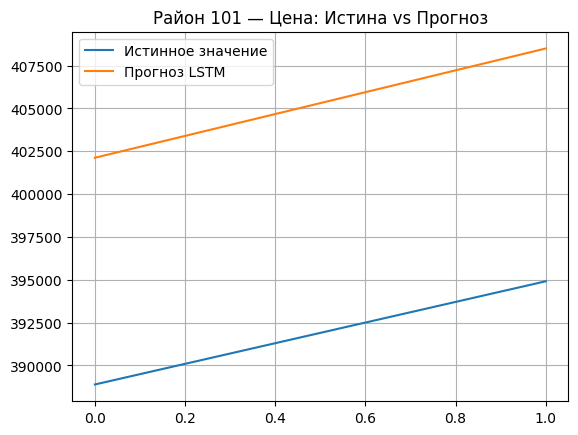

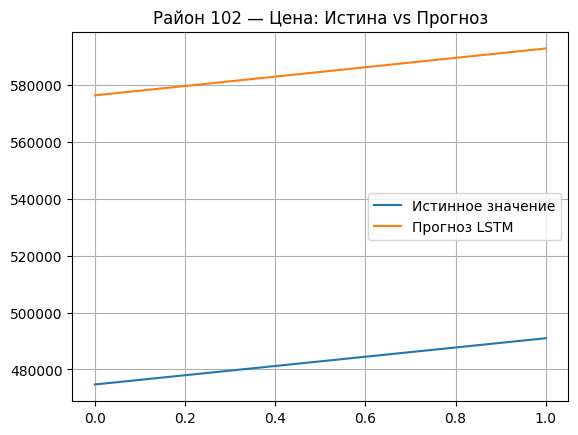

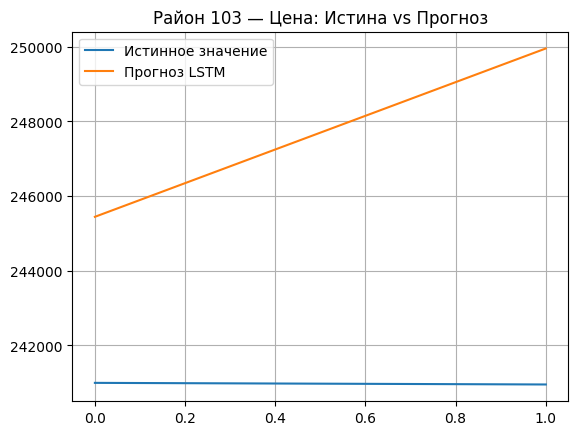

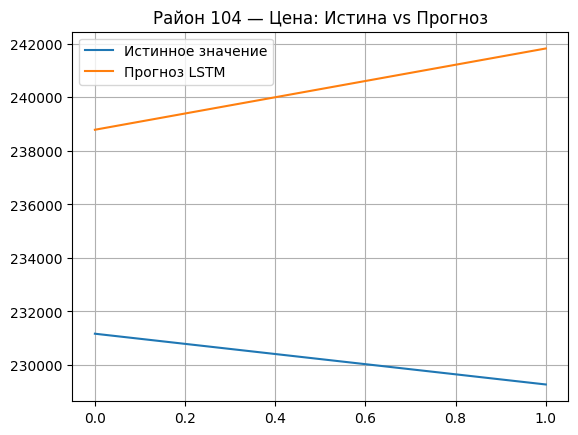

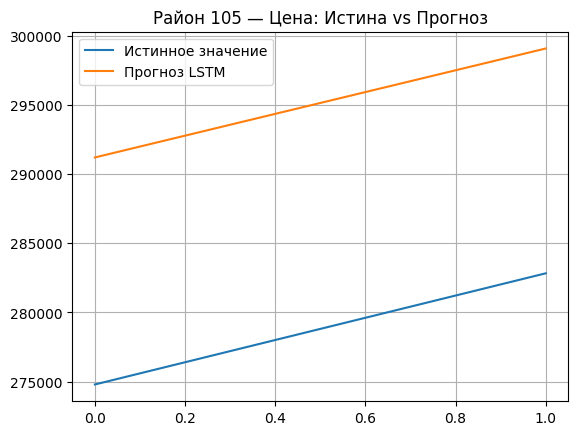

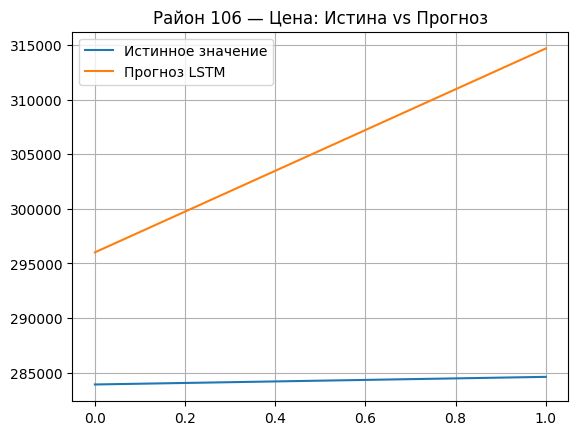

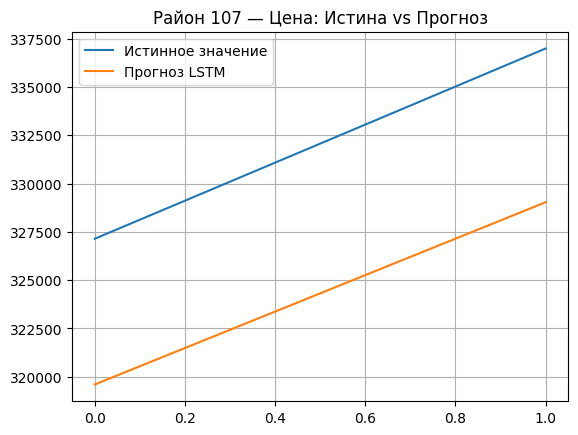

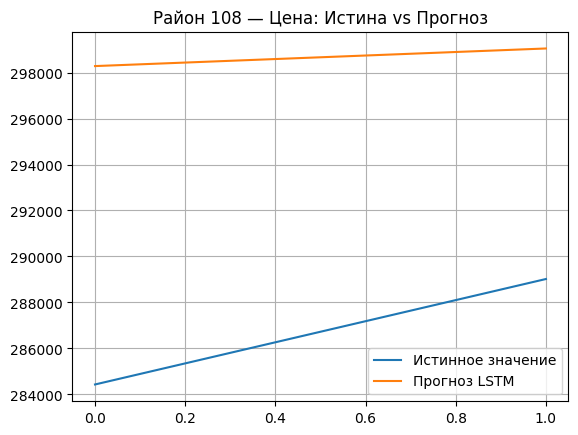

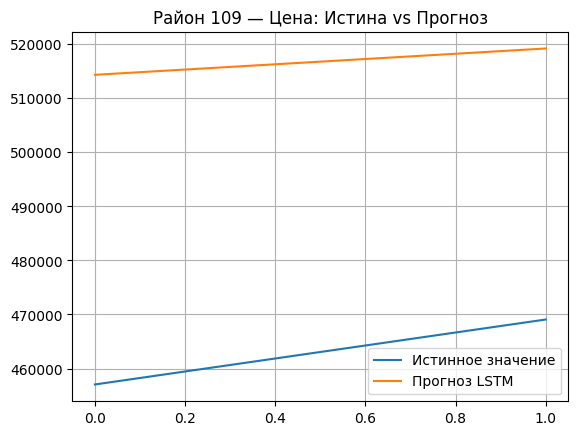

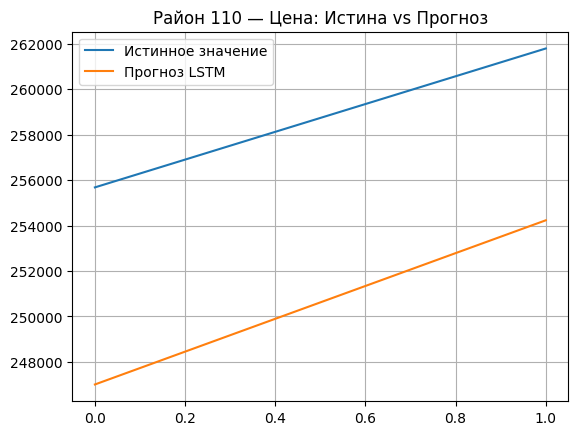

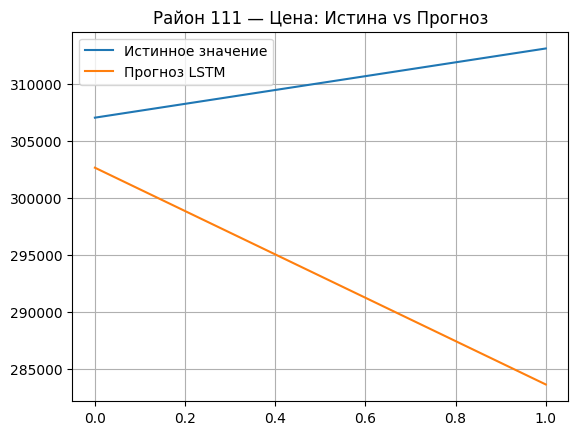

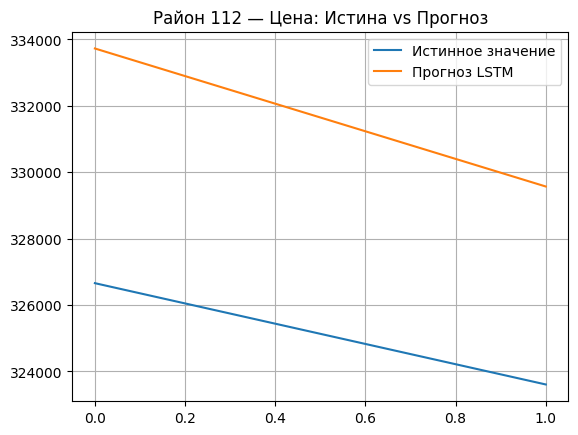

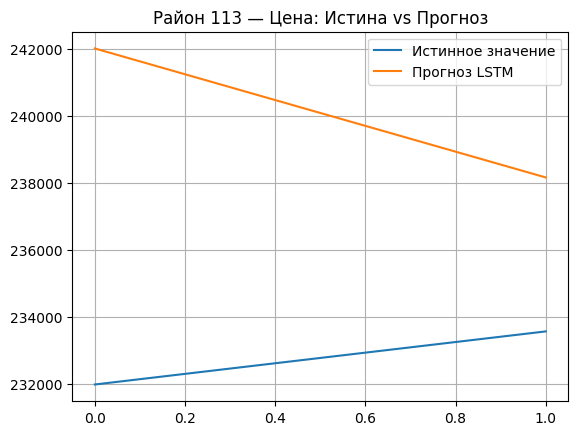

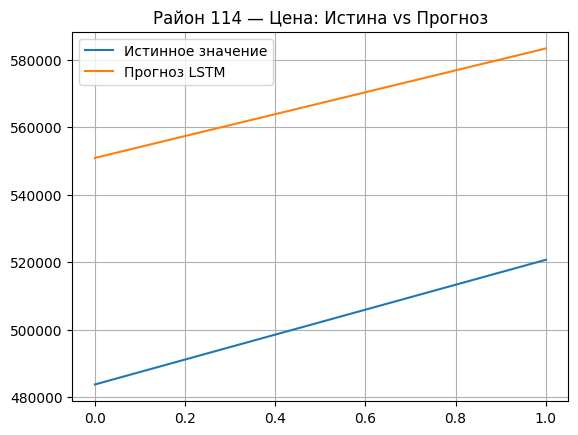

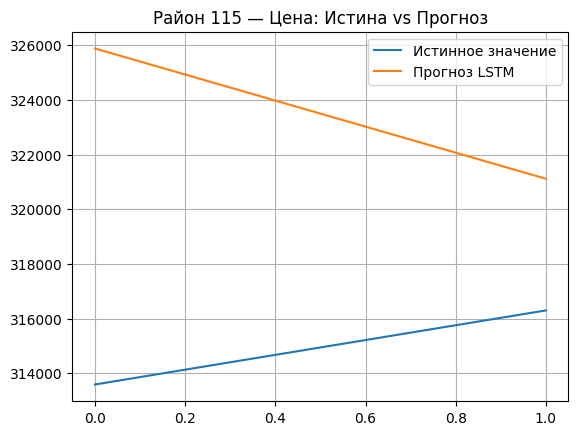

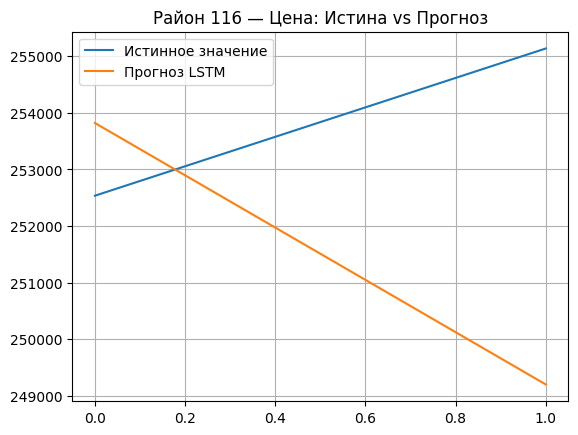

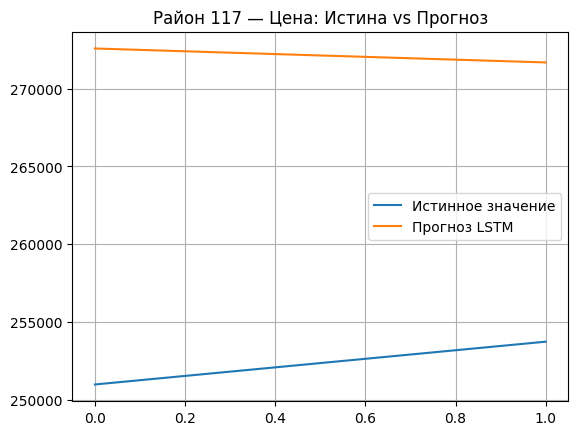

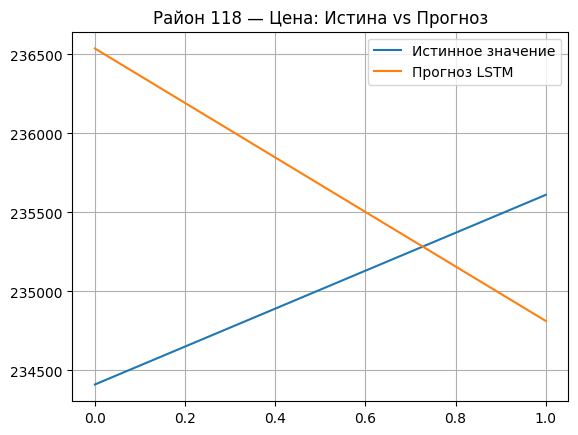

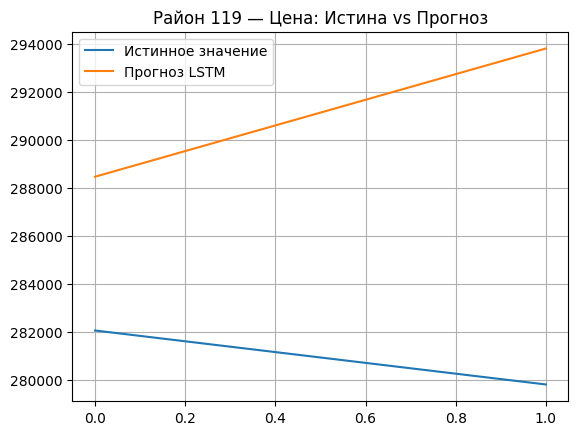

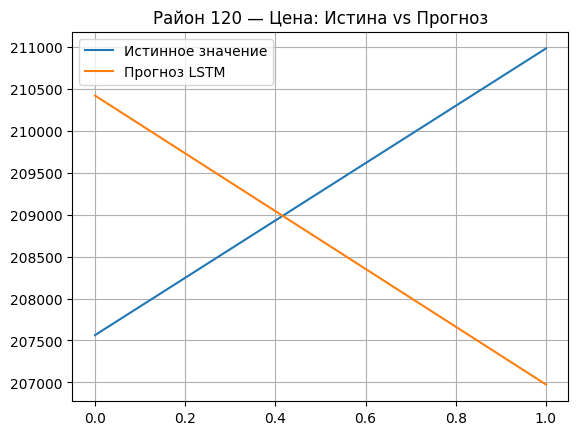

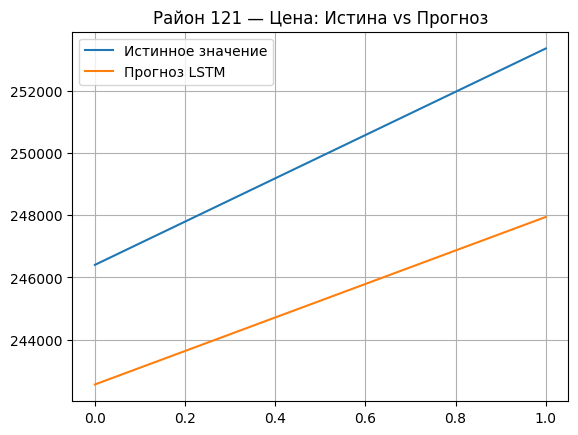

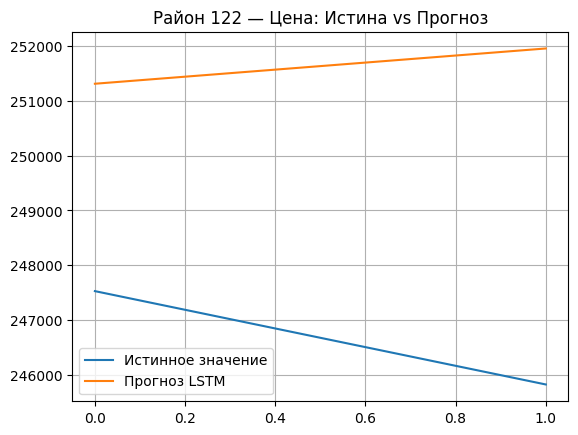

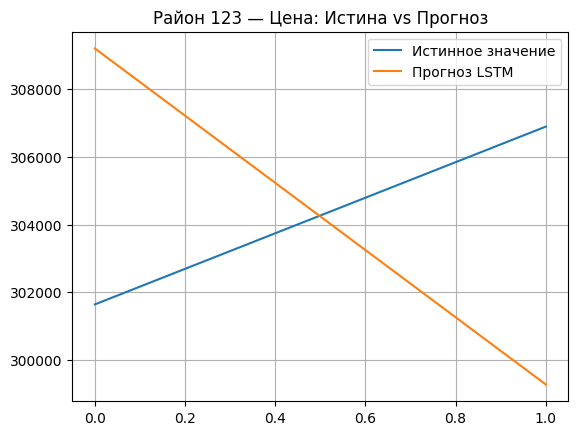

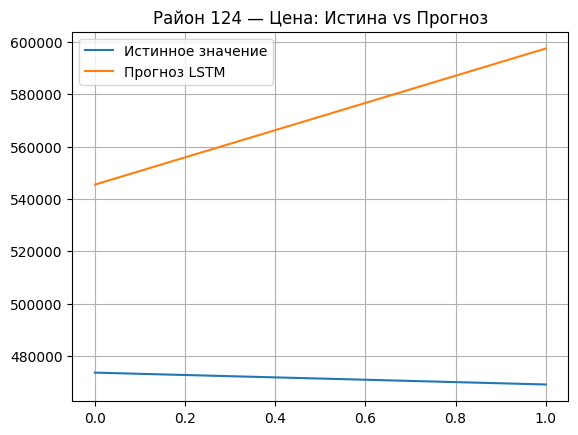

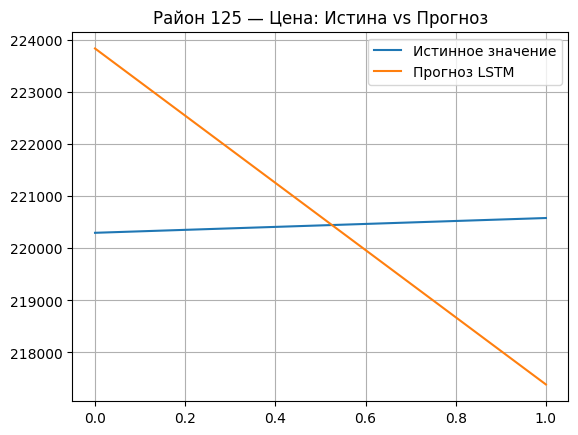

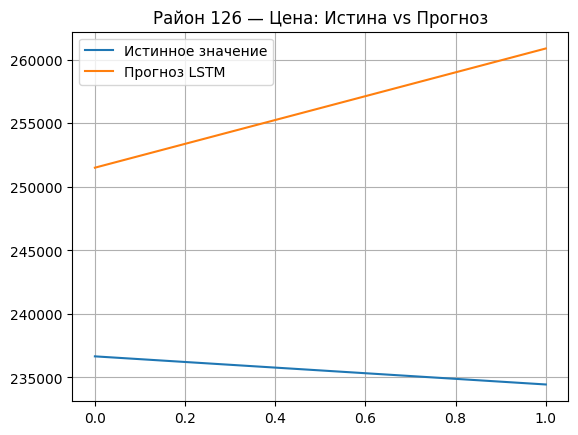

In [19]:
import matplotlib.pyplot as plt

for rayon in range(0, 127):

    plt.plot(y_test_inv_all[rayon], label='Истинное значение')
    plt.plot(y_pred_inv_all[rayon], label='Прогноз LSTM')
    plt.title(f'Район {rayon} — Цена: Истина vs Прогноз')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
total_metrics = pd.DataFrame(columns=["MAE", "MSE", "RMSE", "MAPE (%)", "R2 Score"])
for rayon in range(0, 127):
    current_metrics = evaluate_model(y_test_inv_all[rayon], y_pred_inv_all[rayon])
    total_metrics.loc[len(total_metrics)] = current_metrics

In [12]:
total_metrics.mean()

MAE         1.546292e+04
MSE         6.555589e+08
RMSE        1.603887e+04
MAPE (%)    4.925245e+00
R2 Score   -1.176921e+03
dtype: float64

In [14]:
total_pred = []
total_test = []

In [15]:
for rayon in range(0, 127):
    # print(y_test_inv_all[rayon])

    total_test.append(y_test_inv_all[rayon])
    total_pred.append(y_pred_inv_all[rayon])

In [16]:
total_test = np.vstack(total_test).flatten()

In [17]:
total_pred = np.vstack(total_pred).flatten()

In [18]:
evaluate_model(total_test, total_pred)

{'MAE': 15462.923722287383,
 'MSE': 655558899.0042388,
 'RMSE': np.float64(25603.88445147023),
 'MAPE (%)': np.float64(4.925245306162742),
 'R2 Score': 0.8661290817800503}

In [21]:
rayon = 5

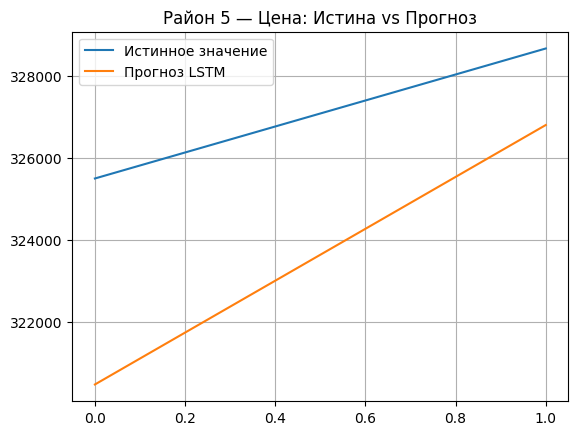

In [22]:
    plt.plot(y_test_inv_all[rayon], label='Истинное значение')
    plt.plot(y_pred_inv_all[rayon], label='Прогноз LSTM')
    plt.title(f'Район {rayon} — Цена: Истина vs Прогноз')
    plt.legend()
    plt.grid(True)
    plt.show()